# **Lab 4.2 NN MLP and CNN**

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid
from datetime import datetime
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize(32)`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(45),`
- `transforms.CenterCrop(28)`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [86]:
# def get_base_dataset(ds):
#     # ไล่ลึก dataset จริง (ไม่ใช่ Subset)
#     while hasattr(ds, 'dataset'):
#         ds = ds.dataset
#     return ds

# def show_subset_detail(subset, data_name):
#     base_ds = get_base_dataset(subset)

#     # ดึง mapping class_to_idx (ถ้ามี)
#     if hasattr(base_ds, 'class_to_idx'):
#         class_map = base_ds.class_to_idx
#     else:
#         class_map = {}

#     # ดึง labels ของ subset ตาม indices
#     if hasattr(subset, 'indices') and hasattr(base_ds, 'targets'):
#         targets = [base_ds.targets[i] for i in subset.indices]
#     elif hasattr(base_ds, 'targets'):
#         targets = base_ds.targets
#     elif hasattr(base_ds, 'labels'):
#         targets = base_ds.labels
#     else:
#         targets = []

#     class_counts = Counter(targets)

#     print(f"{data_name} Dataset:")
#     for label in sorted(class_counts.keys()):
#         print(f"\tNumber of images in class {label}: {class_counts[label]}")

#     print(f"\tNumber of {data_name.lower()} samples: {len(subset)}")

# def show_img(data_loader):
      
#       images, labels = next(iter(data_loader))

#       fig = plt.figure(figsize=(10, 10))
#       plt.style.use('dark_background')

#       grid = ImageGrid(fig, 111,
#                         nrows_ncols=(4, 4),  
#                         axes_pad=0.5,  
#                         )

#       for ax, im, lb in zip(grid, images, labels):
#             im_np = im.permute(1, 2, 0).numpy()
#             ax.axis('off')
#             ax.set_title(str(lb.item()))
#             ax.imshow(im_np, cmap='gray')

#       plt.show()

# def load_data(path,class_names):
#     ### START CODE HERE ###
#     transform = transforms.Compose([
#         transforms.Grayscale(num_output_channels=1),
#         transforms.Pad(20, padding_mode='edge'),
#         transforms.Resize(32),
#         transforms.RandomRotation(25, fill=255),
#         transforms.CenterCrop(28),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.5], std=[0.5])
#     ])

#     dataset = ImageFolder(root=path, transform=transform)

#     class_to_idx = dataset.class_to_idx  
#     selected_class_idxs = [class_to_idx[name] for name in class_names]

#     indices = [i for i, (_, label) in enumerate(dataset) if label in selected_class_idxs]

#     filtered_dataset = Subset(dataset, indices)     # สร้าง Subset ของ dataset เฉพาะ 2 คลาสนี้
#     labels = [dataset.targets[i] for i in indices]  # ดึง label ของ subset สำหรับการแบ่ง train/test

#     train_idx, test_idx = train_test_split(list(range(len(filtered_dataset))), test_size=0.2, stratify=labels, random_state=42) # แบ่ง train/test โดยใช้ sklearn

#     train_dataset = Subset(filtered_dataset, train_idx)
#     test_dataset = Subset(filtered_dataset, test_idx)

#     train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

#     show_subset_detail(train_dataset,"Train")
#     show_subset_detail(test_dataset,"Test")
#     show_img(train_loader)
#     ### END CODE HERE ###
    
#     return train_loader, test_loader

def load_data(path, class_names):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Pad(20, padding_mode='edge'),
        transforms.Resize(32),
        transforms.RandomRotation(25, fill=255),
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    dataset = ImageFolder(root=path, transform=transform)
    class_to_idx = dataset.class_to_idx
    selected_class_idxs = [class_to_idx[name] for name in class_names]

    indices = [i for i, (_, label) in enumerate(dataset) if label in selected_class_idxs]
    filtered_dataset = Subset(dataset, indices)
    labels = [dataset.targets[i] for i in indices]

    train_idx, test_idx = train_test_split(
        list(range(len(filtered_dataset))),
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    train_dataset = Subset(filtered_dataset, train_idx)
    test_dataset = Subset(filtered_dataset, test_idx)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    # Print dataset info
    train_targets = [labels[i] for i in train_idx]
    test_targets = [labels[i] for i in test_idx]
    print("📃Train Dataset:")
    print(f"\tNumber of images in class {selected_class_idxs[0]}: {train_targets.count(selected_class_idxs[0])}")
    print(f"\tNumber of images in class {selected_class_idxs[1]}: {train_targets.count(selected_class_idxs[1])}")
    print(f"\tNumber of training samples: {len(train_targets)}\n")
    print("📃Test Dataset:")
    print(f"\tNumber of images in class {selected_class_idxs[0]}: {test_targets.count(selected_class_idxs[0])}")
    print(f"\tNumber of images in class {selected_class_idxs[1]}: {test_targets.count(selected_class_idxs[1])}")
    print(f"\tNumber of testing samples: {len(test_targets)}")

    # Optional: show_subset_detail(train_dataset, "Train")
    # Optional: show_subset_detail(test_dataset, "Test")
    # Optional: show_img(train_loader)

    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/03.png?raw=true)

</details>

📃Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of testing samples: 156
torch.Size([16, 1, 28, 28]) torch.Size([16])


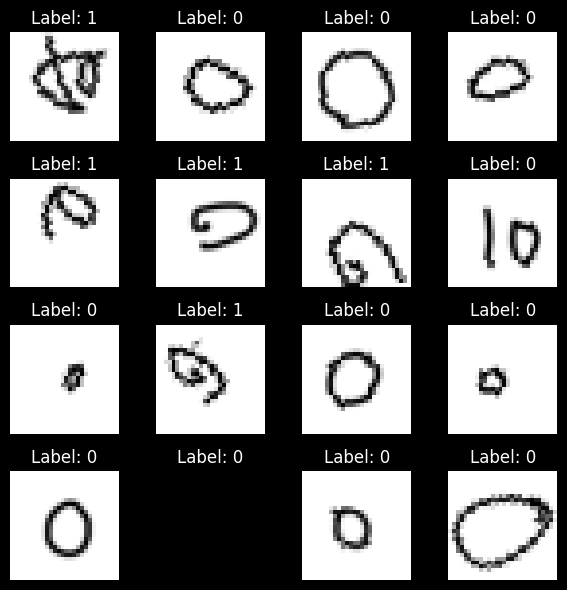

In [87]:
### START CODE HERE ###
class_names = [f'{x}' for x in range(2)]
train_loader, test_loader = load_data("thai/thai",class_names)

fig = plt.figure(figsize=(6, 6))
for images, labels in train_loader:
    print(images.shape, labels.shape)
    for i in range(min(16, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        img = images[i].squeeze().numpy()
        if img.ndim == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img.transpose(1, 2, 0), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    break


### END CODE HERE ###

**Create Models**
1. **NN (Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Single fully connected layer with sigmoid activation
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a simple feedforward neural network with a single fully connected layer. It takes input images, flattens them, passes through a fully connected layer, and applies sigmoid activation to produce the output.

2. **MLP (Multi-Layer Perceptron)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two fully connected layers with sigmoid activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a multi-layer perceptron with two fully connected layers. After flattening the input images, it passes through the first fully connected layer with sigmoid activation, followed by the second fully connected layer with sigmoid activation, producing the output.

3. **CNN (Convolutional Neural Network)**:
- **Input**: 28x28 grayscale images (1 channel)
- **Architecture**: Two convolutional layers with ReLU activations, followed by two fully connected layers with ReLU activations
- **Output**: Single neuron output with sigmoid activation
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


Every model should have a `get_features()` method that returns the result from all layers.

In [88]:
### START CODE HERE ###
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(28 * 28, 1)  # Hidden layer
        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):
        feature_maps = {}

        print(x.shape)
        feature_maps['origin'] = x.detach().cpu()  # Original input (28x28)

        x = self.flatten(x)  # 128-dim features
        print(x.shape)
        feature_maps['flatten'] = x.detach().cpu()  # Flattened features

        x = self.fc(x)  # Final output (1-dim)
        print(x.shape)
        feature_maps['fc'] = x.detach().cpu()

        x = self.sigmoid(x)  # Sigmoid activation
        print(x.shape)
        feature_maps['sigmoid'] = x.detach().cpu()

        return feature_maps  # return all for visualization

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x
    
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 48)
        self.sigmoid1 = nn.Sigmoid()
        self.fc2 = nn.Linear(48, 1)
        self.sigmoid2 = nn.Sigmoid()
    
    def get_features(self,x):
        feature_maps = {}

        feature_maps['origin'] = x.detach().cpu() 
        x = self.flatten(x) 

        feature_maps['flatten'] = x.detach().cpu()          
        x = self.fc1(x)  

        feature_maps['fc1'] = x.detach().cpu()  
        x = self.sigmoid1(x)

        feature_maps['sigmoid1'] = x.detach().cpu()
        x = self.fc2(x)  

        feature_maps['fc2'] = x.detach().cpu()
        x = self.sigmoid2(x) 

        feature_maps['sigmoid2'] = x.detach().cpu()

        return feature_maps

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.sigmoid1(x)
        x = self.fc2(x)
        x = self.sigmoid2(x)
        return x
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def get_features(self, x):
        feature_maps = {}

        feature_maps['origin'] = x.detach().cpu()  # Original input (28x28)
        x = self.conv1(x)

        feature_maps['conv1'] = x.detach().cpu()  # After conv1 (32 channels)
        x = self.pool(F.relu(x))

        feature_maps['pool1'] = x.detach().cpu()
        x = self.conv2(x)

        feature_maps['conv2'] = x.detach().cpu()
        x = self.pool(F.relu(x))

        feature_maps['pool2'] = x.detach().cpu()
        x = x.view(x.size(0), -1)

        feature_maps['flatten'] = x.detach().cpu()  # Flattened features
        x = self.fc1(x)

        feature_maps['fc1'] = x.detach().cpu()
        x = self.fc2(x)

        feature_maps['fc2'] = x.detach().cpu()
        x = self.sigmoid(x)

        feature_maps['sigmoid'] = x.detach().cpu()

        return feature_maps

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.pool(F.relu(x))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x


### END CODE HERE ###

Complete the function below. This function will be used to display the feature map from the models at every epoch on TensorBoard.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical
- `NN()`<br>
![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/04.png?raw=true)
- `MLP()`<br>
![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/05.png?raw=true)
- `CNN()`<br>
![image-3.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/06.png?raw=true)
</details>

torch.Size([16, 1, 28, 28])
torch.Size([16, 784])
torch.Size([16, 1])
torch.Size([16, 1])


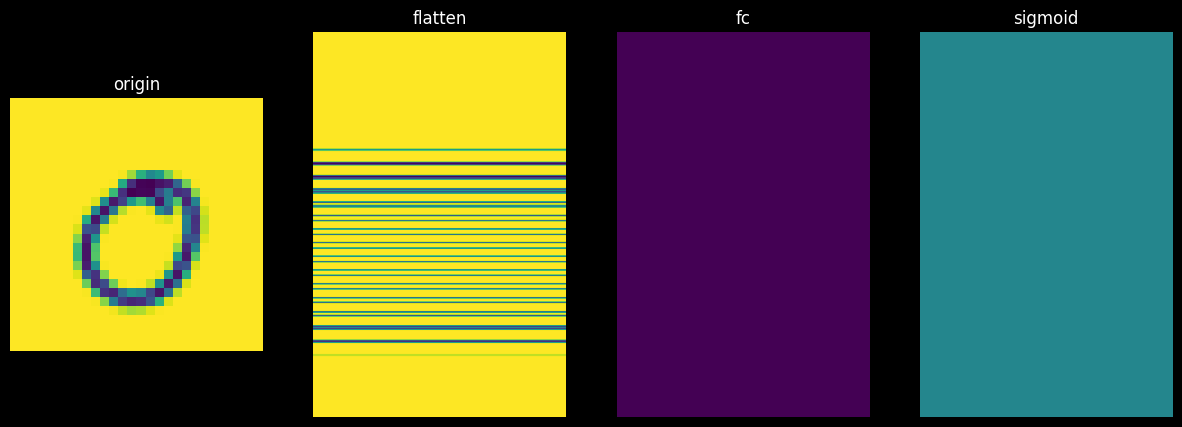

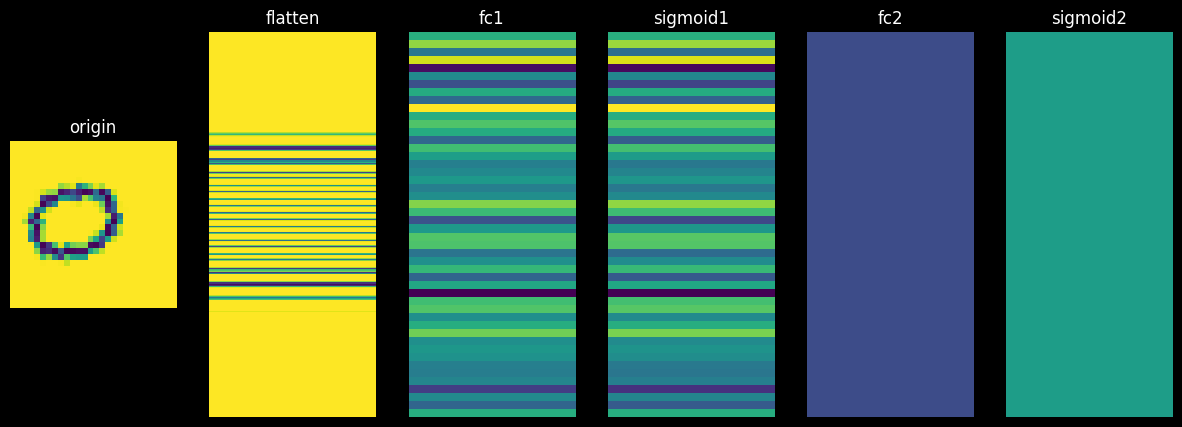

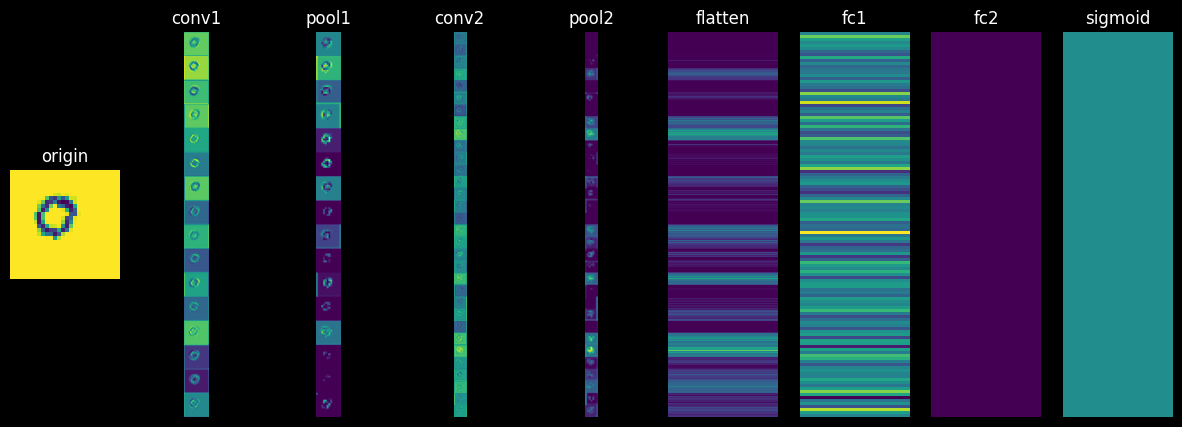

In [89]:
def show_featuremaps(features):
    fig, axs = plt.subplots(1, len(features), figsize=(15, 5))
    plt.style.use('dark_background')

    for ax, (name, feat) in zip(axs, features.items()):
        f = feat[0].cpu().numpy()

        if f.ndim == 3:
            if f.shape[0] == 1:
                ax.imshow(f[0])
            else:
                channels = []
                for i in range(f.shape[0]):
                    channels.append(f[i])
                f_stacked = np.vstack(channels)
                ax.imshow(f_stacked)
        
        elif f.ndim == 1:
            if f.shape[0] > 1:
                ax.imshow(f.reshape(-1, 1), aspect='auto')
            else:
                f_display = np.array([[f.item()]])
                ax.imshow(f_display, aspect='auto', vmin=0, vmax=1)

        ax.set_title(name)
        ax.axis('off')

show_featuremaps(NN().get_features(next(iter(train_loader))[0]))
show_featuremaps(MLP().get_features(next(iter(train_loader))[0]))
show_featuremaps(CNN().get_features(next(iter(train_loader))[0]))



TensorBoard 101

Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy, and display the feature map from all layers of the model at every epoch on TensorBoard. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html)

<details>
<summary>
<font size="3" color="orange">
<b>Expected output that will be display on TensorBoard</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/07.png?raw=true)

![image-2.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/08.png?raw=true)
</details>

In [90]:
def train(class_names, model, opt, loss_fn, train_loader, test_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    model = model.to(device)
    class_map = {int(class_names[0]): 0, int(class_names[1]): 1}
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_accuracy': []}
    print(f"N_Train:{len(train_loader.dataset)}")
    if torch.cuda.is_available(): 
        print("Using GPU for training")

    for epoch in range(epochs):
        print("_____________________________________________________________________________________________________")
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            
            images, labels = images.to(device), labels.to(device)
            labels = torch.tensor([class_map[int(l)] for l in labels], dtype=torch.float32, device=device).unsqueeze(1)


            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).long()
            correct += (predicted.view(-1) == labels.view(-1)).sum().item()
            total += labels.size(0)

        
        print("Output:", outputs.squeeze().tolist())
        print("Predicted:", predicted.squeeze().int().cpu().numpy())
        print("Label:    ", labels.squeeze().int().cpu().numpy())
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct / len(train_loader.dataset)

        # Validation
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Validation {epoch+1}/{epochs}"):
                images, labels = images.to(device), labels.to(device)
                labels = torch.tensor([class_map[int(l)] for l in labels], dtype=torch.float32, device=device).unsqueeze(1)
                
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                test_loss += loss.item()
                predicted = (outputs > 0.5).long()
                correct += (predicted.view(-1) == labels.view(-1)).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader.dataset)
        test_accuracy = correct / len(test_loader.dataset)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        GREEN = '\033[92m'
        YELLOW = '\033[93m'
        RESET = '\033[0m'

        print(f"{GREEN}🔥Epoch [{epoch+1}/{epochs}], 🔥Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"🔥Test Loss: {test_loss:.4f}, 🔥Test Accuracy: {test_accuracy:.4f}{RESET}")

        if writer:
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/test', test_loss, epoch)
            writer.add_scalar('Accuracy/train', train_accuracy, epoch)
            writer.add_scalar('Accuracy/test', test_accuracy, epoch)
            writer.flush()
            
        if checkpoint_path and epoch == epochs-1:
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            model_path = checkpoint_path
            torch.save(model.state_dict(), model_path)

    writer.close()
    print("🔥Training complete.")
    print(f"Final Training Loss: {GREEN}{history['train_loss'][-1]}{RESET}")
    print(f"Final Training Accuracy: {GREEN}{history['train_acc'][-1]}{RESET}")
    print(f"Final Test Loss: {GREEN}{history['test_loss'][-1]}{RESET}")
    print(f"Final Test Accuracy: {GREEN}{history['test_accuracy'][-1]}{RESET}")
    
    return history
            
# train(class_names, NN(), 
#       torch.optim.Adam(NN().parameters(), lr=0.001), 
#       nn.BCEWithLogitsLoss(), train_loader, test_loader, 
#       epochs=30, writer=SummaryWriter(log_dir='runs/nn_experiment'), 
#       checkpoint_path='nn_checkpoint.pth', device='cuda' if torch.cuda.is_available() else 'cpu')

# import os

# def train(class_names,model,opt,loss_fn,train_loader,test_loader,epochs=10,writer=None,checkpoint_path=None,device='cpu'):
#     ### START CODE HERE ###
    
#     model = model.to(device)
#     class_map = {int(class_names[0]): 0, int(class_names[1]): 1}
#     history = {
#         'train_loss':[],
#         'train_acc':[],
#         'test_loss':[],
#         'test_acc':[]
#     }

#     for epoch in range(epochs):
#         model.train()
#         train_bar = tqdm(train_loader, desc=f'Training Epoch [{epoch+1}/{epochs}]', unit='batch')

#         total_train_loss = 0
#         total_train_correct = 0

#         for images, labels in train_bar:
#             images = images.to(device)
#             labels = labels.cpu().numpy()
#             labels = torch.tensor([class_map[int(l)] for l in labels], dtype=torch.float32, device=device).unsqueeze(1)

#             opt.zero_grad()
#             output = model(images)
#             loss = loss_fn(output, labels)
#             loss.backward()
#             opt.step()
            
#             total_train_loss += loss.item()
#             predicted = (output > 0.6).long()  # output เป็น sigmoid -> 0~1
#             total_train_correct += (predicted == labels).sum().item()

#             train_bar.set_postfix(loss=loss.item())
            
#         # print("output: ",output.squeeze().tolist())
#         # print("Predicted: ", predicted.squeeze().tolist())
#         # print("Label:     ", labels.squeeze().long().tolist())
        
#         avg_train_loss = total_train_loss/len(train_loader)
#         avg_train_acc = total_train_correct/len(train_loader.dataset)
        
#         history['train_loss'].append(avg_train_loss)
#         history['train_acc'].append(avg_train_acc)


#         #testing-----------------------------------------------------------------------------------
#         model.eval()
#         test_bar = tqdm(test_loader, desc='Testing 🧐🧐', unit='batch')

#         total_test_loss = 0
#         total_test_correct = 0

#         with torch.no_grad():
#             for images, labels in test_bar:
#                 images = images.to(device)
#                 labels = labels.cpu().numpy()
#                 labels = torch.tensor([class_map[int(l)] for l in labels], dtype=torch.float32, device=device).unsqueeze(1)

                
#                 # labels = labels.to(device)
#                 # labels = labels.float().unsqueeze(1)

#                 output = model(images)
#                 loss = loss_fn(output, labels)

#                 total_test_loss += loss.item()
#                 predicted = (output > 0.6).long()
#                 total_test_correct += (predicted == labels).sum().item()

#                 test_bar.set_postfix(loss=loss.item())
        
#         avg_test_loss = total_test_loss / len(test_loader)
#         avg_test_acc = total_test_correct / len(test_loader.dataset)

#         history['test_loss'].append(avg_test_loss)
#         history['test_acc'].append(avg_test_acc)

#         if epoch == epochs-1:
#             print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc:.4f}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}\n")

#         if writer:
#             writer.add_scalar("Loss/train", avg_train_loss, epoch)
#             writer.add_scalar("Accuracy/train", avg_train_acc, epoch)
#             writer.add_scalar("Loss/test", avg_test_loss, epoch)
#             writer.add_scalar("Accuracy/test", avg_test_acc, epoch)
#             writer.flush() 

#         if checkpoint_path and epoch == epochs-1:
#             os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
#             model_path = checkpoint_path
#             torch.save(model.state_dict(), model_path)
        
#     writer.close()
#     return history

    ### END CODE HERE ###


            
            






    ### END CODE HERE ###

Use your `train()` function to train all types of models with all combinations of numbers that you've obtained.

In [91]:
### START CODE HERE ###
combination = []
for i in range(0,10):
      for j in range(1,10):
        if i<j :
            combination.append([str(i),str(j)])
            
cn_and_loader = []
for com in combination:
      class_names = com
      train_loader, test_loader = load_data('thai/thai',class_names)
      cn_and_loader.append((class_names,train_loader,test_loader))

### END CODE HERE ###

📃Train Dataset:
	Number of images in class 0: 310
	Number of images in class 1: 311
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 78
	Number of images in class 1: 78
	Number of testing samples: 156
📃Train Dataset:
	Number of images in class 0: 310
	Number of images in class 2: 311
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 78
	Number of images in class 2: 78
	Number of testing samples: 156
📃Train Dataset:
	Number of images in class 0: 310
	Number of images in class 3: 310
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 78
	Number of images in class 3: 78
	Number of testing samples: 156
📃Train Dataset:
	Number of images in class 0: 310
	Number of images in class 4: 310
	Number of training samples: 620

📃Test Dataset:
	Number of images in class 0: 78
	Number of images in class 4: 78
	Number of testing samples: 156
📃Train Dataset:
	Number of images in class 0: 310
	Number of images in class

In [92]:
writer = SummaryWriter(log_dir='runs/cnn')

cnn_model = CNN() 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

for cl in cn_and_loader:
    class_names,train_loader,test_loader  = cl

    device = 'cpu'

    cnn_history = train(
        class_names,
        cnn_model,
        optimizer,
        loss_fn,
        train_loader,
        test_loader,
        epochs=5,
        writer=writer,
        checkpoint_path=f"checkpoints/cnn_model/{class_names}.pth",
        device=device,
    )


N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 35.50it/s]


Output: [0.46299612522125244, 0.4181209206581116, 0.42106109857559204, 0.42420071363449097, 0.4009302258491516, 0.4773087799549103, 0.49315112829208374, 0.418336421251297, 0.4883742332458496, 0.47413870692253113, 0.460856556892395, 0.43895676732063293, 0.40060901641845703]
Predicted: [0 0 0 0 0 0 0 0 0 0 0 0 0]
Label:     [1 1 0 0 0 1 1 0 1 0 1 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.36it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0424, Train Accuracy: 0.5620, 🔥Test Loss: 0.0412, 🔥Test Accuracy: 0.7244
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.33it/s]


Output: [0.7854966521263123, 0.2189026027917862, 0.5802381634712219, 0.8593645691871643, 0.4415329098701477, 0.7249338030815125, 0.4301537871360779, 0.26242879033088684, 0.21425971388816833, 0.4627131521701813, 0.8731577396392822, 0.7402987480163574, 0.20738112926483154]
Predicted: [1 0 1 1 0 1 0 0 0 0 1 1 0]
Label:     [1 0 0 1 0 0 0 0 0 1 1 1 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 33.38it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0355, Train Accuracy: 0.7536, 🔥Test Loss: 0.0302, 🔥Test Accuracy: 0.7821
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.06it/s]


Output: [0.4764873683452606, 0.06383229047060013, 0.6015863418579102, 0.7769069671630859, 0.5028690099716187, 0.06873258948326111, 0.7918687462806702, 0.12365569174289703, 0.9498546123504639, 0.11353867501020432, 0.9685788750648499, 0.7921847701072693, 0.2116900086402893]
Predicted: [0 0 1 1 1 0 1 0 1 0 1 1 0]
Label:     [0 0 0 1 1 0 1 0 1 0 1 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.68it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0277, Train Accuracy: 0.8084, 🔥Test Loss: 0.0273, 🔥Test Accuracy: 0.7821
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.87it/s]


Output: [0.13418060541152954, 0.7282031774520874, 0.6072732210159302, 0.960239052772522, 0.8687461614608765, 0.9778459668159485, 0.7440667152404785, 0.12270122766494751, 0.99367755651474, 0.9932098984718323, 0.7945153713226318, 0.23507989943027496, 0.24248075485229492]
Predicted: [0 1 1 1 1 1 1 0 1 1 1 0 0]
Label:     [0 0 0 1 1 0 1 0 1 1 1 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 34.93it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0228, Train Accuracy: 0.8502, 🔥Test Loss: 0.0236, 🔥Test Accuracy: 0.8590
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 35.80it/s]


Output: [0.13383981585502625, 0.9668681621551514, 0.4296204447746277, 0.5736416578292847, 0.9137828350067139, 0.9139119982719421, 0.22797846794128418, 0.9792606234550476, 0.22797846794128418, 0.2956060767173767, 0.9915095567703247, 0.3259564936161041, 0.8157086372375488]
Predicted: [0 1 0 1 1 1 0 1 0 0 1 0 1]
Label:     [0 1 0 0 1 1 0 1 0 0 1 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.64it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0217, Train Accuracy: 0.8551, 🔥Test Loss: 0.0220, 🔥Test Accuracy: 0.8526
🔥Training complete.
Final Training Loss: 0.021664894481404007
Final Training Accuracy: 0.855072463768116
Final Test Loss: 0.02200095059397893
Final Test Accuracy: 0.8525641025641025
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.23it/s]


Output: [0.047234635800123215, 0.9944711923599243, 0.09309354424476624, 0.9937132000923157, 0.8970102071762085, 0.21639762818813324, 0.2331095039844513, 0.9577996134757996, 0.0983816459774971, 0.08545951545238495, 0.034889668226242065, 0.7556840777397156, 0.04614417254924774]
Predicted: [0 1 0 1 1 0 0 1 0 0 0 1 0]
Label:     [0 1 0 1 1 0 0 0 0 0 0 1 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 39.68it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0224, Train Accuracy: 0.8406, 🔥Test Loss: 0.0210, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.56it/s]


Output: [0.3546474277973175, 0.44766852259635925, 0.08148054778575897, 0.9244993925094604, 0.1893308311700821, 0.016428114846348763, 0.013612381182610989, 0.598732590675354, 0.7666264772415161, 0.016237134113907814, 0.9987770915031433, 0.9845011234283447, 0.04610724747180939]
Predicted: [0 0 0 1 0 0 0 1 1 0 1 1 0]
Label:     [1 0 1 1 0 0 0 1 0 0 1 1 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 38.36it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0150, Train Accuracy: 0.9082, 🔥Test Loss: 0.0174, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.86it/s]


Output: [0.9998769760131836, 0.9991810917854309, 0.2215961366891861, 0.9970241189002991, 0.9969075322151184, 0.9998714923858643, 0.10599830001592636, 0.8771291375160217, 0.2359427660703659, 0.9935729503631592, 0.978812575340271, 0.9946105480194092, 0.9994115829467773]
Predicted: [1 1 0 1 1 1 0 1 0 1 1 1 1]
Label:     [1 1 0 1 1 1 0 1 0 1 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.12it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0143, Train Accuracy: 0.9243, 🔥Test Loss: 0.0176, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 35.00it/s]


Output: [0.9743525981903076, 0.9997588992118835, 0.014913317747414112, 0.05962672457098961, 0.038396913558244705, 0.01019914261996746, 0.8296032547950745, 0.051690977066755295, 0.12575414776802063, 0.9250811338424683, 0.017332779243588448, 0.8456386923789978, 0.040598537772893906]
Predicted: [1 1 0 0 0 0 1 0 0 1 0 1 0]
Label:     [1 1 0 1 0 0 0 0 1 1 0 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 34.67it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0125, Train Accuracy: 0.9291, 🔥Test Loss: 0.0151, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.74it/s]


Output: [0.9981938004493713, 0.6238902807235718, 0.09643043577671051, 0.06595712155103683, 0.970313310623169, 0.051974162459373474, 0.043475739657878876, 0.8735475540161133, 0.8872215747833252, 0.9640262126922607, 0.5503365397453308, 0.0694931373000145, 0.9976497292518616]
Predicted: [1 1 0 0 1 0 0 1 1 1 1 0 1]
Label:     [1 1 0 0 1 0 0 1 1 1 0 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.61it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0113, Train Accuracy: 0.9291, 🔥Test Loss: 0.0167, 🔥Test Accuracy: 0.9167
🔥Training complete.
Final Training Loss: 0.011279298961402522
Final Training Accuracy: 0.92914653784219
Final Test Loss: 0.016663517755193587
Final Test Accuracy: 0.9166666666666666
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.80it/s]


Output: [0.0705796405673027, 0.9612618088722229, 0.9560269713401794, 0.1326359659433365, 0.9999929666519165, 0.9999706745147705, 0.9614962935447693, 0.12924952805042267, 0.9893286824226379, 0.9357428550720215, 0.3637084364891052, 0.6638891100883484]
Predicted: [0 1 1 0 1 1 1 0 1 1 0 1]
Label:     [0 1 1 0 1 1 1 0 1 1 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.98it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0193, Train Accuracy: 0.8581, 🔥Test Loss: 0.0623, 🔥Test Accuracy: 0.8654
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 35.40it/s]


Output: [0.9970498085021973, 0.2956894636154175, 0.01385121513158083, 0.03156190365552902, 0.9987687468528748, 0.9947699904441833, 0.9993525147438049, 0.837994396686554, 0.999911904335022, 0.9980512857437134, 0.08609272539615631, 0.040744658559560776]
Predicted: [1 0 0 0 1 1 1 1 1 1 0 0]
Label:     [1 0 0 0 1 1 1 1 1 1 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 38.88it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0149, Train Accuracy: 0.8919, 🔥Test Loss: 0.0223, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 31.54it/s]


Output: [0.9995114803314209, 0.18274471163749695, 0.014797136187553406, 0.970162034034729, 0.34542304277420044, 0.9510781168937683, 0.01659861020743847, 0.011904999613761902, 0.9969016313552856, 0.3193562924861908, 0.9999868869781494, 0.9998538494110107]
Predicted: [1 0 0 1 0 1 0 0 1 0 1 1]
Label:     [1 0 0 1 0 1 0 0 1 0 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.79it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0131, Train Accuracy: 0.9177, 🔥Test Loss: 0.0563, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.09it/s]


Output: [0.2976588010787964, 0.2976588010787964, 0.007860145531594753, 0.0796632394194603, 0.8985711932182312, 0.2976588010787964, 0.41905564069747925, 0.3510461151599884, 0.9994113445281982, 0.9963490962982178, 0.9963153004646301, 0.5419561266899109]
Predicted: [0 0 0 0 1 0 0 0 1 1 1 1]
Label:     [1 0 0 0 1 0 0 1 1 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 38.71it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0143, Train Accuracy: 0.9113, 🔥Test Loss: 0.0179, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.69it/s]


Output: [0.1739484816789627, 0.40132224559783936, 0.3661677837371826, 0.0032239595893770456, 0.9841342568397522, 0.012972192838788033, 0.9460152983665466, 0.05962544307112694, 0.3661677837371826, 0.8577170372009277, 0.07767617702484131, 0.07964960485696793]
Predicted: [0 0 0 0 1 0 1 0 0 1 0 0]
Label:     [0 1 0 0 1 0 0 0 0 1 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.16it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0142, Train Accuracy: 0.9032, 🔥Test Loss: 0.0186, 🔥Test Accuracy: 0.9103
🔥Training complete.
Final Training Loss: 0.014249715392267511
Final Training Accuracy: 0.9032258064516129
Final Test Loss: 0.018588500909316234
Final Test Accuracy: 0.9102564102564102
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.91it/s]


Output: [0.7272788882255554, 0.9948877692222595, 0.24726475775241852, 0.02095302753150463, 0.03112921118736267, 0.28675705194473267, 0.9761669635772705, 0.7164588570594788, 0.9232386350631714, 0.24726475775241852, 0.02597581036388874, 0.9995344877243042]
Predicted: [1 1 0 0 0 0 1 1 1 0 0 1]
Label:     [1 1 1 0 0 0 1 1 1 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 33.18it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0182, Train Accuracy: 0.8758, 🔥Test Loss: 0.0513, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 30.97it/s]


Output: [0.28295066952705383, 0.14646108448505402, 0.9999194145202637, 0.012181990779936314, 0.0037201636005192995, 0.9394969940185547, 0.014997592195868492, 0.0011630733497440815, 0.9999569654464722, 0.11449533700942993, 0.28295066952705383, 0.6545116901397705]
Predicted: [0 0 1 0 0 1 0 0 1 0 0 1]
Label:     [0 0 1 0 0 1 0 0 1 0 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 32.95it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0108, Train Accuracy: 0.9242, 🔥Test Loss: 0.0510, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 28.64it/s]


Output: [0.9999985694885254, 0.04557895287871361, 0.9999544620513916, 0.005061902571469545, 0.9656946659088135, 0.2433752864599228, 0.01645904965698719, 0.2433752864599228, 0.0054312897846102715, 0.9998999834060669, 0.9425234794616699, 0.9957897067070007]
Predicted: [1 0 1 0 1 0 0 0 0 1 1 1]
Label:     [1 0 1 0 1 0 0 1 0 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 33.00it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0090, Train Accuracy: 0.9355, 🔥Test Loss: 0.0488, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.72it/s]


Output: [0.0028628783766180277, 0.9998941421508789, 0.9999961853027344, 0.9999321699142456, 0.0006873764214105904, 1.0, 0.05241374298930168, 0.03478306904435158, 0.999993085861206, 0.9925408363342285, 0.9999940395355225, 0.043540459126234055]
Predicted: [0 1 1 1 0 1 0 0 1 1 1 0]
Label:     [0 1 1 1 0 1 0 0 1 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 34.00it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0084, Train Accuracy: 0.9339, 🔥Test Loss: 0.0519, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 31.16it/s]


Output: [0.002960681449621916, 0.006582864094525576, 4.969491419615224e-05, 0.0005021593533456326, 0.0015298103680834174, 0.976554811000824, 0.9970964193344116, 0.9999876022338867, 0.9999277591705322, 0.9999872446060181, 0.008306601084768772, 0.9999979734420776]
Predicted: [0 0 0 0 0 1 1 1 1 1 0 1]
Label:     [0 0 0 0 0 1 1 1 1 1 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.54it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0072, Train Accuracy: 0.9484, 🔥Test Loss: 0.0490, 🔥Test Accuracy: 0.9231
🔥Training complete.
Final Training Loss: 0.007222620912662316
Final Training Accuracy: 0.9483870967741935
Final Test Loss: 0.049004063049020864
Final Test Accuracy: 0.9230769230769231
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.95it/s]


Output: [0.9999990463256836, 0.21189606189727783, 0.0037446576170623302, 0.3570075035095215, 0.999941349029541, 0.005879499483853579, 0.0832357406616211, 0.3570075035095215, 0.0440426729619503, 0.08461857587099075, 0.002002353547140956, 0.3570075035095215]
Predicted: [1 0 0 0 1 0 0 0 0 0 0 0]
Label:     [1 0 0 1 1 0 0 0 1 0 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.98it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0104, Train Accuracy: 0.9290, 🔥Test Loss: 0.0496, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.00it/s]


Output: [0.18046554923057556, 0.01463429257273674, 0.40623703598976135, 1.0, 0.9983131885528564, 0.9999996423721313, 0.9999991655349731, 0.008060725405812263, 0.9999982118606567, 0.9999996423721313, 0.9999991655349731, 0.9941900968551636]
Predicted: [0 0 0 1 1 1 1 0 1 1 1 1]
Label:     [0 0 0 1 1 1 1 0 1 1 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.98it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0085, Train Accuracy: 0.9355, 🔥Test Loss: 0.0480, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 31.71it/s]


Output: [6.640815990976989e-05, 0.03907303884625435, 0.0038560281973332167, 0.0013126437552273273, 0.003135896986350417, 1.0, 0.36592960357666016, 0.0016454916913062334, 0.9983091354370117, 0.002816826105117798, 0.9984163045883179, 0.000708165520336479]
Predicted: [0 0 0 0 0 1 0 0 1 0 1 0]
Label:     [0 0 0 0 0 1 0 0 1 0 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 29.89it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0074, Train Accuracy: 0.9419, 🔥Test Loss: 0.0476, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 30.32it/s]


Output: [0.9989445805549622, 0.9999997615814209, 0.9999974966049194, 0.9999407529830933, 0.03712158650159836, 0.00013986982230562717, 0.3317558467388153, 0.9307252168655396, 0.019708756357431412, 9.202837100019678e-05, 0.9999549388885498, 0.0031725349836051464]
Predicted: [1 1 1 1 0 0 0 1 0 0 1 0]
Label:     [1 1 1 1 1 0 1 1 0 0 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 37.20it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0068, Train Accuracy: 0.9435, 🔥Test Loss: 0.0486, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.88it/s]


Output: [0.01984342932701111, 0.23627762496471405, 0.0057030972093343735, 0.030899258330464363, 1.0, 0.06803709268569946, 0.9999982118606567, 0.09069837629795074, 1.0, 0.9999997615814209, 0.014499041251838207, 0.9999955892562866]
Predicted: [0 0 0 0 1 0 1 0 1 1 0 1]
Label:     [0 0 0 0 1 0 1 0 1 1 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 38.83it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0073, Train Accuracy: 0.9435, 🔥Test Loss: 0.0520, 🔥Test Accuracy: 0.9295
🔥Training complete.
Final Training Loss: 0.007321731687613553
Final Training Accuracy: 0.9435483870967742
Final Test Loss: 0.05201459315438301
Final Test Accuracy: 0.9294871794871795
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.72it/s]


Output: [0.00796852819621563, 0.018908387050032616, 0.6587502360343933, 0.9985804557800293, 0.337056964635849, 0.08717954903841019, 0.9971718192100525, 0.8118895292282104, 0.9899932742118835, 0.9994713664054871, 0.24838237464427948, 0.9591256380081177]
Predicted: [0 0 1 1 0 0 1 1 1 1 0 1]
Label:     [0 0 1 1 0 0 1 1 1 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.92it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0183, Train Accuracy: 0.8726, 🔥Test Loss: 0.0560, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.07it/s]


Output: [0.9998881816864014, 0.005353775806725025, 0.027255432680249214, 0.9952601790428162, 0.9982646107673645, 0.4140286445617676, 0.3764187693595886, 0.005900237709283829, 0.005739493761211634, 0.9999948740005493, 0.003690388984978199, 0.9999983310699463]
Predicted: [1 0 0 1 1 0 0 0 0 1 0 1]
Label:     [1 0 0 1 1 1 0 0 0 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 35.89it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0128, Train Accuracy: 0.9016, 🔥Test Loss: 0.0530, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.94it/s]


Output: [0.9998495578765869, 0.999923586845398, 0.07798442244529724, 0.3215828239917755, 0.010558206588029861, 0.9932686686515808, 0.7652599215507507, 0.9990808963775635, 0.24507713317871094, 0.40773892402648926, 0.04250826686620712, 0.40773892402648926]
Predicted: [1 1 0 0 0 1 1 1 0 0 0 0]
Label:     [1 1 0 0 0 1 0 1 0 0 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.67it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0102, Train Accuracy: 0.9258, 🔥Test Loss: 0.0559, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.33it/s]


Output: [0.9999529123306274, 0.004675909411162138, 0.6464828848838806, 0.9848811626434326, 0.9587967991828918, 0.005634679459035397, 0.001471581868827343, 0.006125869695097208, 0.2154710292816162, 0.9240303635597229, 0.075679250061512, 0.0054580941796302795]
Predicted: [1 0 1 1 1 0 0 0 0 1 0 0]
Label:     [1 0 0 1 1 0 0 0 1 1 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 36.43it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0103, Train Accuracy: 0.9210, 🔥Test Loss: 0.0540, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 31.40it/s]


Output: [0.45687633752822876, 0.3647029399871826, 0.9820988178253174, 0.308747798204422, 0.9969391822814941, 0.3647029399871826, 0.028744244948029518, 0.9999972581863403, 0.0008211158565245569, 0.03422277420759201, 0.3647029399871826, 0.8094222545623779]
Predicted: [0 0 1 0 1 0 0 1 0 0 0 1]
Label:     [1 0 1 1 1 1 1 1 0 0 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 34.63it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0097, Train Accuracy: 0.9210, 🔥Test Loss: 0.0192, 🔥Test Accuracy: 0.8974
🔥Training complete.
Final Training Loss: 0.009733435508584784
Final Training Accuracy: 0.9209677419354839
Final Test Loss: 0.01922325662170083
Final Test Accuracy: 0.8974358974358975
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.17it/s]


Output: [0.9999942779541016, 0.5620348453521729, 0.0036923284642398357, 0.9999803304672241, 1.0, 1.0, 0.44784852862358093, 0.3225388526916504, 0.04449137672781944, 0.44784852862358093, 0.03627772629261017, 0.998190701007843]
Predicted: [1 1 0 1 1 1 0 0 0 0 0 1]
Label:     [1 0 0 1 1 1 0 1 0 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 31.35it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0107, Train Accuracy: 0.9210, 🔥Test Loss: 0.0534, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 31.30it/s]


Output: [0.8905836939811707, 0.9999864101409912, 0.9941826462745667, 0.9716018438339233, 0.9999936819076538, 0.0005783813539892435, 0.9994779229164124, 0.11735665798187256, 0.02575535885989666, 0.9839247465133667, 0.01902793161571026, 1.0]
Predicted: [1 1 1 1 1 0 1 0 0 1 0 1]
Label:     [1 1 1 0 1 0 1 0 0 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.03it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0092, Train Accuracy: 0.9339, 🔥Test Loss: 0.0505, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 31.18it/s]


Output: [0.4088502526283264, 0.0013970694271847606, 0.055208899080753326, 0.0063415830954909325, 0.018043266609311104, 0.9628653526306152, 0.999983549118042, 0.0017003888497129083, 0.9999998807907104, 0.9999991655349731, 0.9995421171188354, 1.0]
Predicted: [0 0 0 0 0 1 1 0 1 1 1 1]
Label:     [0 0 0 0 0 1 1 0 1 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 36.81it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0088, Train Accuracy: 0.9355, 🔥Test Loss: 0.0517, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.24it/s]


Output: [0.005449727177619934, 2.7304535251460038e-05, 0.9991341233253479, 0.0004947515553794801, 0.9999996423721313, 0.007564200554043055, 0.0017917848890647292, 0.9971150159835815, 0.9036567807197571, 0.07178378850221634, 1.0, 1.0]
Predicted: [0 0 1 0 1 0 0 1 1 0 1 1]
Label:     [0 0 1 0 1 0 0 1 1 0 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 32.00it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0073, Train Accuracy: 0.9468, 🔥Test Loss: 0.0509, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.93it/s]


Output: [0.00058165960945189, 0.9999959468841553, 0.004785056225955486, 0.0020107238087803125, 1.0, 0.0008034843485802412, 0.9946460723876953, 0.004045536741614342, 0.1815759837627411, 0.9998356103897095, 0.0003893740358762443, 0.1296660453081131]
Predicted: [0 1 0 0 1 0 1 0 0 1 0 0]
Label:     [0 1 0 0 1 0 1 0 0 1 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 39.14it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0078, Train Accuracy: 0.9355, 🔥Test Loss: 0.0520, 🔥Test Accuracy: 0.9231
🔥Training complete.
Final Training Loss: 0.007808621427524955
Final Training Accuracy: 0.9354838709677419
Final Test Loss: 0.05201033444907994
Final Test Accuracy: 0.9230769230769231
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.35it/s]


Output: [0.9999971389770508, 0.9763710498809814, 0.9985950589179993, 0.9884049892425537, 0.0014994506491348147, 0.3907168507575989, 0.9021824598312378, 0.00650995085015893, 0.0024312192108482122, 0.16041924059391022, 0.9997398257255554, 0.0027488935738801956]
Predicted: [1 1 1 1 0 0 1 0 0 0 1 0]
Label:     [1 1 1 1 0 0 1 0 0 0 1 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.07it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0147, Train Accuracy: 0.8871, 🔥Test Loss: 0.0208, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.79it/s]


Output: [0.1786048263311386, 0.003438830841332674, 0.9999983310699463, 0.999991774559021, 0.7762202620506287, 0.3737417459487915, 0.19921337068080902, 0.9999759197235107, 0.004767749924212694, 0.9994342923164368, 0.9925588369369507, 0.9999665021896362]
Predicted: [0 0 1 1 1 0 0 1 0 1 1 1]
Label:     [1 0 1 1 1 0 1 1 0 1 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 40.07it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0136, Train Accuracy: 0.9097, 🔥Test Loss: 0.0527, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.28it/s]


Output: [0.9995488524436951, 0.9999371767044067, 0.9999946355819702, 0.000287699862383306, 0.0017822837689891458, 0.9842360019683838, 0.013913149945437908, 0.0077035678550601006, 0.023263176903128624, 0.38909193873405457, 0.9999994039535522, 0.9971718192100525]
Predicted: [1 1 1 0 0 1 0 0 0 0 1 1]
Label:     [1 1 1 0 0 1 0 0 0 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 36.01it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0092, Train Accuracy: 0.9323, 🔥Test Loss: 0.0514, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.07it/s]


Output: [0.9981542229652405, 0.0001820516336010769, 0.9976243376731873, 0.007479055318981409, 0.0009655677131377161, 0.46049079298973083, 0.9151727557182312, 0.10157527774572372, 0.004743664525449276, 0.46049079298973083, 0.07686218619346619, 0.8927457928657532]
Predicted: [1 0 1 0 0 0 1 0 0 0 0 1]
Label:     [1 0 1 0 0 1 0 0 0 0 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 33.21it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0087, Train Accuracy: 0.9355, 🔥Test Loss: 0.0534, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.20it/s]


Output: [0.9999873638153076, 0.0761541947722435, 0.004272297490388155, 0.9999966621398926, 0.9998462200164795, 0.0008309594704769552, 0.012494281865656376, 0.9942296743392944, 0.0013104641111567616, 0.9994462132453918, 0.0018375349463894963, 0.07179506868124008]
Predicted: [1 0 0 1 1 0 0 1 0 1 0 0]
Label:     [1 0 0 1 1 0 0 1 0 1 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.92it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0080, Train Accuracy: 0.9339, 🔥Test Loss: 0.0534, 🔥Test Accuracy: 0.9231
🔥Training complete.
Final Training Loss: 0.007982223879005159
Final Training Accuracy: 0.9338709677419355
Final Test Loss: 0.05339559060163223
Final Test Accuracy: 0.9230769230769231
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.91it/s]


Output: [0.9999053478240967, 0.04349246621131897, 0.9999595880508423, 0.48071062564849854, 0.9855055212974548, 0.4255434274673462, 0.015407158993184566, 0.9217487573623657, 0.33416813611984253, 0.05101363733410835, 0.9999598264694214, 0.48071062564849854]
Predicted: [1 0 1 0 1 0 0 1 0 0 1 0]
Label:     [1 0 1 0 1 0 0 1 0 0 1 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.61it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0101, Train Accuracy: 0.9306, 🔥Test Loss: 0.0521, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 31.35it/s]


Output: [0.9989607334136963, 0.9962054491043091, 0.9999970197677612, 0.0028399170842021704, 0.9999816417694092, 0.9998006224632263, 0.42041870951652527, 0.9999973773956299, 0.9972142577171326, 0.002261847723275423, 0.9999932050704956, 0.12193792313337326]
Predicted: [1 1 1 0 1 1 0 1 1 0 1 0]
Label:     [1 1 1 0 1 1 0 1 1 0 1 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 37.68it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0078, Train Accuracy: 0.9339, 🔥Test Loss: 0.0511, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 31.08it/s]


Output: [0.0002034229109995067, 0.9970132112503052, 0.39046478271484375, 0.4388269782066345, 0.0003033239918295294, 0.999907374382019, 0.00011961409472860396, 0.9960158467292786, 0.9626699686050415, 0.6767668724060059, 0.9375700354576111, 5.7650388043839484e-05]
Predicted: [0 1 0 0 0 1 0 1 1 1 1 0]
Label:     [0 1 0 1 0 1 0 1 1 1 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 32.44it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0070, Train Accuracy: 0.9468, 🔥Test Loss: 0.0520, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 35.16it/s]


Output: [0.0003554841678123921, 0.9996961355209351, 0.9995576739311218, 0.00034428801154717803, 0.0029774238355457783, 0.005585134960711002, 0.261320024728775, 0.0003865305334329605, 0.7609120607376099, 0.9978718757629395, 0.9764856100082397, 0.00032521222601644695]
Predicted: [0 1 1 0 0 0 0 0 1 1 1 0]
Label:     [0 1 1 0 0 0 0 0 1 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 34.19it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0072, Train Accuracy: 0.9290, 🔥Test Loss: 0.0490, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 31.24it/s]


Output: [1.0, 1.0, 0.008275287225842476, 0.4612461030483246, 0.0001370167447021231, 0.0006584268994629383, 0.9999713897705078, 0.019797060638666153, 0.9998840093612671, 0.06949245929718018, 0.4612461030483246, 0.00012306132703088224]
Predicted: [1 1 0 0 0 0 1 0 1 0 0 0]
Label:     [1 1 1 0 0 0 1 0 1 0 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 32.11it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0069, Train Accuracy: 0.9387, 🔥Test Loss: 0.0582, 🔥Test Accuracy: 0.9231
🔥Training complete.
Final Training Loss: 0.006908276900198431
Final Training Accuracy: 0.9387096774193548
Final Test Loss: 0.05822358126990879
Final Test Accuracy: 0.9230769230769231
N_Train:622
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 28.73it/s]


Output: [0.11762144416570663, 0.19143587350845337, 0.6683046221733093, 0.5247230529785156, 0.016764067113399506, 0.8481006026268005, 0.10482367873191833, 0.10719545930624008, 0.051728393882513046, 0.8789415955543518, 0.29189532995224, 0.6297919154167175, 0.9089885354042053, 0.9084704518318176]
Predicted: [0 0 1 1 0 1 0 0 0 1 0 1 1 1]
Label:     [0 0 1 1 0 1 0 0 0 0 1 1 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 30.70it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0357, Train Accuracy: 0.7733, 🔥Test Loss: 0.0227, 🔥Test Accuracy: 0.8397
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 31.34it/s]


Output: [0.8750234842300415, 0.9933260679244995, 0.11551370471715927, 0.012099280022084713, 0.02372153103351593, 0.9873600602149963, 0.04055285081267357, 0.4899490773677826, 0.8703871965408325, 0.014713053591549397, 0.9728489518165588, 0.9860325455665588, 0.875483512878418, 0.09672974795103073]
Predicted: [1 1 0 0 0 1 0 0 1 0 1 1 1 0]
Label:     [1 1 0 0 0 1 0 0 1 0 1 1 1 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.21it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0164, Train Accuracy: 0.8955, 🔥Test Loss: 0.0183, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.65it/s]


Output: [0.1024528369307518, 0.9968147873878479, 0.2304162085056305, 0.998416543006897, 0.03671548515558243, 0.9959434866905212, 0.9862008690834045, 0.9982731342315674, 0.04982507601380348, 0.988189697265625, 0.9325119256973267, 0.5030624270439148, 0.9977339506149292, 0.9877523183822632]
Predicted: [0 1 0 1 0 1 1 1 0 1 1 1 1 1]
Label:     [0 1 0 1 0 1 1 1 0 1 1 0 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.12it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0153, Train Accuracy: 0.8955, 🔥Test Loss: 0.0192, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 31.94it/s]


Output: [0.9992027878761292, 0.04009975492954254, 0.9118151068687439, 0.017953872680664062, 0.95992511510849, 0.8961721658706665, 0.05082526430487633, 0.9425294995307922, 0.12832079827785492, 0.9996799230575562, 0.0013113148743286729, 0.09143861383199692, 0.9990980625152588, 0.947860062122345]
Predicted: [1 0 1 0 1 1 0 1 0 1 0 0 1 1]
Label:     [1 0 1 0 1 1 0 1 0 1 0 0 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.08it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0119, Train Accuracy: 0.9084, 🔥Test Loss: 0.0202, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.54it/s]


Output: [0.10178723931312561, 0.9881110191345215, 0.9993252754211426, 0.035637009888887405, 0.9999805688858032, 0.2732674777507782, 0.007041058968752623, 0.07613693922758102, 0.005534191150218248, 0.36649125814437866, 0.06554295867681503, 0.007858376018702984, 0.010419090278446674, 0.9902476668357849]
Predicted: [0 1 1 0 1 0 0 0 0 0 0 0 0 1]
Label:     [1 1 1 0 1 0 0 0 0 0 0 0 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.27it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0115, Train Accuracy: 0.9260, 🔥Test Loss: 0.0159, 🔥Test Accuracy: 0.9295
🔥Training complete.
Final Training Loss: 0.011504467289259962
Final Training Accuracy: 0.9260450160771704
Final Test Loss: 0.01588120447615018
Final Test Accuracy: 0.9294871794871795
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.05it/s]


Output: [0.06058880314230919, 0.9924374222755432, 0.9857408404350281, 0.8554297089576721, 0.0027837760280817747, 0.6420238614082336, 0.8194284439086914, 0.1826573759317398, 0.4099571406841278, 0.934810996055603, 0.9511452317237854, 0.9891323447227478, 0.9273171424865723]
Predicted: [0 1 1 1 0 1 1 0 0 1 1 1 1]
Label:     [0 1 1 1 0 1 1 0 1 1 1 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.15it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0247, Train Accuracy: 0.8325, 🔥Test Loss: 0.0211, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.63it/s]


Output: [0.9990142583847046, 0.675417423248291, 0.6053403615951538, 0.8126150965690613, 0.667022705078125, 0.00533465389162302, 0.030753767117857933, 0.045972418040037155, 0.0013016656739637256, 0.9897662997245789, 0.9897156357765198, 0.029665278270840645, 0.34912198781967163]
Predicted: [1 1 1 1 1 0 0 0 0 1 1 0 0]
Label:     [1 1 1 1 1 0 1 0 0 1 1 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 30.01it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0164, Train Accuracy: 0.8889, 🔥Test Loss: 0.0177, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.35it/s]


Output: [0.9781473278999329, 0.7191562652587891, 0.5293635129928589, 0.9984292387962341, 0.41935667395591736, 0.0039171078242361546, 0.8778638243675232, 0.9938147068023682, 0.006488454062491655, 0.999847412109375, 0.9461398124694824, 0.9745713472366333, 0.9953765869140625]
Predicted: [1 1 1 1 0 0 1 1 0 1 1 1 1]
Label:     [1 1 0 1 0 0 1 1 0 1 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.99it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0151, Train Accuracy: 0.9066, 🔥Test Loss: 0.0189, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.51it/s]


Output: [0.9756879806518555, 0.8006414771080017, 0.0007105118711479008, 0.9188089370727539, 0.592062771320343, 0.0005908061284571886, 0.9842556118965149, 0.001765547669492662, 0.9711059331893921, 0.9001280069351196, 0.99118971824646, 0.6104150414466858, 0.30879920721054077]
Predicted: [1 1 0 1 1 0 1 0 1 1 1 1 0]
Label:     [1 1 0 0 1 0 1 0 1 1 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 32.80it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0145, Train Accuracy: 0.9018, 🔥Test Loss: 0.0234, 🔥Test Accuracy: 0.8526
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.82it/s]


Output: [0.01354333758354187, 0.06163457781076431, 0.9881131052970886, 0.22034205496311188, 0.5148982405662537, 0.988584041595459, 0.010236082598567009, 0.9446536898612976, 0.9943469166755676, 0.0008947468595579267, 0.9957188963890076, 0.9763283133506775, 0.9993820190429688]
Predicted: [0 0 1 0 1 1 0 1 1 0 1 1 1]
Label:     [0 0 1 0 1 1 0 1 1 0 1 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.38it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0128, Train Accuracy: 0.9227, 🔥Test Loss: 0.0199, 🔥Test Accuracy: 0.8974
🔥Training complete.
Final Training Loss: 0.012796043665800694
Final Training Accuracy: 0.9227053140096618
Final Test Loss: 0.019878442279803447
Final Test Accuracy: 0.8974358974358975
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.23it/s]


Output: [9.466441042604856e-06, 0.02100508101284504, 0.0006227140547707677, 0.00061379763064906, 0.970174252986908, 0.9974700212478638, 0.9996770620346069, 0.9989808201789856, 0.5665585994720459, 0.9997451901435852, 0.10623371601104736, 0.00010394981654826552, 0.8797655701637268]
Predicted: [0 0 0 0 1 1 1 1 1 1 0 0 1]
Label:     [0 0 0 0 1 1 1 1 0 1 0 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 32.14it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0135, Train Accuracy: 0.8969, 🔥Test Loss: 0.0139, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.37it/s]


Output: [5.3218507673591375e-05, 0.03843295946717262, 0.19122299551963806, 0.003374677849933505, 0.9977295994758606, 0.0018242864171043038, 0.9882839918136597, 2.3384338419418782e-05, 0.9835330843925476, 0.010353825986385345, 0.0008696901495568454, 0.9729431867599487, 0.9251831769943237]
Predicted: [0 0 0 0 1 0 1 0 1 0 0 1 1]
Label:     [0 0 0 0 1 0 1 0 1 0 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 33.15it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0101, Train Accuracy: 0.9291, 🔥Test Loss: 0.0121, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.70it/s]


Output: [0.0019308204064145684, 0.992141604423523, 0.992689311504364, 0.03931748867034912, 0.0004934979369863868, 0.7951899170875549, 0.10410551726818085, 0.9981175661087036, 0.9971621036529541, 0.00013852526899427176, 0.0002239034220110625, 0.997326135635376, 0.0008571827784180641]
Predicted: [0 1 1 0 0 1 0 1 1 0 0 1 0]
Label:     [0 1 1 0 0 1 0 1 1 0 0 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.25it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0078, Train Accuracy: 0.9565, 🔥Test Loss: 0.0108, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.45it/s]


Output: [0.9259887337684631, 0.00430186465382576, 1.0204991667706054e-05, 0.9942903518676758, 3.4158820199081674e-06, 7.000332516327035e-06, 0.9810060262680054, 0.789103090763092, 0.6200302839279175, 0.0015162065392360091, 0.026544714346528053, 0.801403284072876, 0.6101452112197876]
Predicted: [1 0 0 1 0 0 1 1 1 0 0 1 1]
Label:     [1 0 0 1 0 0 1 1 1 0 0 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 33.01it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0060, Train Accuracy: 0.9662, 🔥Test Loss: 0.0106, 🔥Test Accuracy: 0.9679
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 31.99it/s]


Output: [2.0461800886550918e-05, 0.4191907048225403, 0.0005233036354184151, 0.005967562086880207, 0.06070312112569809, 0.986239492893219, 0.9705137014389038, 0.9993178844451904, 0.009208125993609428, 0.9702942371368408, 0.020551113411784172, 2.276684062962886e-05, 2.6742891350295395e-06]
Predicted: [0 0 0 0 0 1 1 1 0 1 0 0 0]
Label:     [0 0 0 0 0 1 1 1 0 1 0 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.19it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0058, Train Accuracy: 0.9646, 🔥Test Loss: 0.0096, 🔥Test Accuracy: 0.9679
🔥Training complete.
Final Training Loss: 0.005772185574875074
Final Training Accuracy: 0.964573268921095
Final Test Loss: 0.009574129538706098
Final Test Accuracy: 0.967948717948718
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.76it/s]


Output: [4.854549843003042e-05, 0.6951502561569214, 0.000858349958434701, 0.9942854046821594, 0.0006229372229427099, 0.003987326752394438, 0.9975188970565796, 0.9206025004386902, 0.988222062587738, 0.16074642539024353, 9.17955840122886e-05, 0.008684216067194939, 0.0002625217312015593]
Predicted: [0 1 0 1 0 0 1 1 1 0 0 0 0]
Label:     [0 1 0 1 0 0 1 1 1 0 0 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 34.43it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0099, Train Accuracy: 0.9452, 🔥Test Loss: 0.0134, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.12it/s]


Output: [0.9868268966674805, 0.6124580502510071, 0.9988697171211243, 0.001600468996912241, 0.0028007752262055874, 0.04935210570693016, 0.012670435942709446, 0.03756356239318848, 0.006407609209418297, 0.9976450800895691, 0.0002380988298682496, 0.08632035553455353, 0.9999717473983765]
Predicted: [1 1 1 0 0 0 0 0 0 1 0 0 1]
Label:     [1 1 1 0 0 0 0 0 0 1 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 35.06it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0066, Train Accuracy: 0.9581, 🔥Test Loss: 0.0148, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 31.70it/s]


Output: [0.999854564666748, 0.9952864050865173, 1.223489903168229e-06, 0.9999508857727051, 0.23353233933448792, 0.001997975865378976, 0.005273146089166403, 0.012342521920800209, 0.9999984502792358, 0.00020630362269002944, 1.445093175789225e-06, 0.06695040315389633, 0.9998900890350342]
Predicted: [1 1 0 1 0 0 0 0 1 0 0 0 1]
Label:     [1 1 0 1 1 0 0 0 1 0 0 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 32.49it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0065, Train Accuracy: 0.9581, 🔥Test Loss: 0.0473, 🔥Test Accuracy: 0.9487
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.22it/s]


Output: [0.7540327310562134, 1.6028039681259543e-05, 0.011371584609150887, 0.0038407135289162397, 0.0026247454807162285, 0.00010859235771931708, 0.9999977350234985, 0.2900644838809967, 0.9999822378158569, 0.0051457686349749565, 0.9998365640640259, 0.0014520696131512523, 0.9999216794967651]
Predicted: [1 0 0 0 0 0 1 0 1 0 1 0 1]
Label:     [1 0 0 0 0 0 1 0 1 0 1 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.62it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0051, Train Accuracy: 0.9630, 🔥Test Loss: 0.0497, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.85it/s]


Output: [0.9318408370018005, 5.749197953264229e-07, 6.92081666784361e-05, 0.9999997615814209, 0.0003094949061051011, 0.9999992847442627, 0.9999971389770508, 4.116435957257636e-05, 0.00040476248250342906, 0.999291181564331, 0.7255101203918457, 0.9982432126998901, 0.9995686411857605]
Predicted: [1 0 0 1 0 1 1 0 0 1 1 1 1]
Label:     [1 0 0 1 0 1 1 0 0 1 1 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.83it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0045, Train Accuracy: 0.9678, 🔥Test Loss: 0.0486, 🔥Test Accuracy: 0.9359
🔥Training complete.
Final Training Loss: 0.004472666467658443
Final Training Accuracy: 0.9677938808373591
Final Test Loss: 0.048609380377456546
Final Test Accuracy: 0.9358974358974359
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.54it/s]


Output: [0.08135531842708588, 0.9997575879096985, 0.9628538489341736, 0.8432613611221313, 0.995164155960083, 0.9996159076690674, 0.0476473830640316, 0.5551347136497498, 0.9938862919807434, 0.11823736131191254, 0.19396522641181946, 0.9894281029701233, 0.9942827224731445]
Predicted: [0 1 1 1 1 1 0 1 1 0 0 1 1]
Label:     [0 1 1 1 1 1 0 1 1 0 0 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 29.26it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0305, Train Accuracy: 0.8164, 🔥Test Loss: 0.0169, 🔥Test Accuracy: 0.8846
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.40it/s]


Output: [0.9746540784835815, 0.9353948831558228, 0.9996267557144165, 0.0006986340740695596, 0.9032225608825684, 0.0012386746238917112, 0.0061875018291175365, 0.027544362470507622, 0.7201488018035889, 0.6492529511451721, 0.919394850730896, 0.07385863363742828, 0.6492529511451721]
Predicted: [1 1 1 0 1 0 0 0 1 1 1 0 1]
Label:     [1 1 1 0 1 0 0 0 1 1 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.37it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0112, Train Accuracy: 0.9340, 🔥Test Loss: 0.0157, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.13it/s]


Output: [0.9999926090240479, 0.00011719806207111105, 0.009468381293118, 0.002345331711694598, 0.7789733409881592, 0.999886155128479, 0.999954342842102, 0.9860197305679321, 0.9999616146087646, 0.00759451137855649, 0.9995381832122803, 0.5871506333351135, 0.9996856451034546]
Predicted: [1 0 0 0 1 1 1 1 1 0 1 1 1]
Label:     [1 0 0 0 1 1 1 1 1 0 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 35.61it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0107, Train Accuracy: 0.9388, 🔥Test Loss: 0.0136, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.02it/s]


Output: [0.9937446713447571, 0.10221774131059647, 0.6726757884025574, 0.0011712834239006042, 0.011350642889738083, 0.011020069941878319, 0.7668288946151733, 0.029119018465280533, 0.010816219262778759, 0.6471072435379028, 0.06274306774139404, 0.9341579079627991, 0.0012589073739945889]
Predicted: [1 0 1 0 0 0 1 0 0 1 0 1 0]
Label:     [1 0 1 0 0 0 0 0 0 1 0 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 36.43it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0098, Train Accuracy: 0.9340, 🔥Test Loss: 0.0181, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.03it/s]


Output: [0.04133213311433792, 0.08216561377048492, 0.20329734683036804, 0.6879408955574036, 0.0016690482152625918, 0.30037882924079895, 0.13406969606876373, 0.004608517978340387, 0.9999945163726807, 0.0028514317236840725, 0.11011943966150284, 0.9963768124580383, 0.0018671322613954544]
Predicted: [0 0 0 1 0 0 0 0 1 0 0 1 0]
Label:     [0 0 1 1 0 0 0 0 1 0 0 1 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.77it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0082, Train Accuracy: 0.9436, 🔥Test Loss: 0.0172, 🔥Test Accuracy: 0.9167
🔥Training complete.
Final Training Loss: 0.008209512275066257
Final Training Accuracy: 0.9436392914653784
Final Test Loss: 0.017210918359267406
Final Test Accuracy: 0.9166666666666666
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.02it/s]


Output: [0.891920804977417, 0.9993066787719727, 0.014049551449716091, 0.9922588467597961, 0.9999314546585083, 0.0010182171827182174, 0.6156361699104309, 0.6354765295982361, 0.9996806383132935, 0.999778687953949, 0.9936961531639099, 0.9999748468399048, 0.028735226020216942]
Predicted: [1 1 0 1 1 0 1 1 1 1 1 1 0]
Label:     [1 1 0 1 1 0 1 1 1 1 1 1 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 32.98it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0105, Train Accuracy: 0.9291, 🔥Test Loss: 0.0133, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.19it/s]


Output: [0.9828333854675293, 0.0020407468546181917, 0.9996179342269897, 0.0006544532952830195, 0.9939568042755127, 0.12950856983661652, 0.0022155134938657284, 0.9999904632568359, 0.6690453886985779, 0.9998400211334229, 0.04607228934764862, 0.9998574256896973, 0.0006769028841517866]
Predicted: [1 0 1 0 1 0 0 1 1 1 0 1 0]
Label:     [1 0 1 0 1 0 0 1 1 1 0 1 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 35.54it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0084, Train Accuracy: 0.9452, 🔥Test Loss: 0.0116, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.75it/s]


Output: [0.3948465883731842, 0.9889227151870728, 0.7184985280036926, 0.2721726894378662, 0.6911983489990234, 0.9984410405158997, 0.00634903647005558, 0.9995817542076111, 4.213833381072618e-05, 0.0007423904025927186, 0.99104905128479, 0.015663612633943558, 0.9999816417694092]
Predicted: [0 1 1 0 1 1 0 1 0 0 1 0 1]
Label:     [1 1 1 0 1 1 0 1 0 0 1 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 30.39it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0067, Train Accuracy: 0.9549, 🔥Test Loss: 0.0132, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.58it/s]


Output: [0.9999549388885498, 0.9999997615814209, 0.014068751595914364, 0.003306408179923892, 0.9997342228889465, 0.012044833973050117, 7.198886305559427e-05, 0.007512891665101051, 0.9993938207626343, 0.003965282347053289, 0.9858328104019165, 9.915915870806202e-05, 0.999971866607666]
Predicted: [1 1 0 0 1 0 0 0 1 0 1 0 1]
Label:     [1 1 0 0 1 0 0 0 1 0 1 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 33.67it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0068, Train Accuracy: 0.9565, 🔥Test Loss: 0.0146, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.96it/s]


Output: [0.6403221487998962, 0.01716035231947899, 0.9988401532173157, 0.998508632183075, 0.9999994039535522, 0.002246070420369506, 0.9998923540115356, 0.6403221487998962, 0.9999947547912598, 0.0003362158895470202, 0.013649874366819859, 0.0026476485654711723, 0.002308921655640006]
Predicted: [1 0 1 1 1 0 1 1 1 0 0 0 0]
Label:     [1 0 1 1 1 0 1 1 1 0 0 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 36.06it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0059, Train Accuracy: 0.9678, 🔥Test Loss: 0.0111, 🔥Test Accuracy: 0.9487
🔥Training complete.
Final Training Loss: 0.005919266645849087
Final Training Accuracy: 0.9677938808373591
Final Test Loss: 0.011071608410789989
Final Test Accuracy: 0.9487179487179487
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.74it/s]


Output: [0.34482553601264954, 0.0014136637328192592, 0.026097368448972702, 0.0003478657454252243, 0.9988553524017334, 0.9990251064300537, 0.9990979433059692, 0.07968474179506302, 0.5033293962478638, 0.9999972581863403, 0.9714193344116211, 0.986778736114502, 0.9999538660049438]
Predicted: [0 0 0 0 1 1 1 0 1 1 1 1 1]
Label:     [1 0 0 0 1 1 1 0 0 1 1 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 35.81it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0137, Train Accuracy: 0.9034, 🔥Test Loss: 0.0139, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 30.04it/s]


Output: [0.1572870910167694, 0.9685685038566589, 0.09706240892410278, 0.0005703407223336399, 0.001619341317564249, 0.14607806503772736, 0.9993610978126526, 0.07142665237188339, 0.1563519686460495, 0.8264139890670776, 0.9999759197235107, 0.9973255395889282, 0.0010467646643519402]
Predicted: [0 1 0 0 0 0 1 0 0 1 1 1 0]
Label:     [0 1 0 0 0 0 1 0 0 1 1 1 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.48it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0081, Train Accuracy: 0.9549, 🔥Test Loss: 0.0516, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.58it/s]


Output: [0.9999942779541016, 0.003645070595666766, 0.0034558791667222977, 0.5482940077781677, 0.0009537675650790334, 0.17699183523654938, 0.9999973773956299, 0.9976819753646851, 0.05848676711320877, 0.006738912779837847, 0.0016841550823301077, 0.9999949932098389, 0.017465274780988693]
Predicted: [1 0 0 1 0 0 1 1 0 0 0 1 0]
Label:     [1 0 0 0 0 0 1 1 0 0 0 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 35.31it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0068, Train Accuracy: 0.9597, 🔥Test Loss: 0.0191, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.50it/s]


Output: [0.9968072175979614, 0.016175691038370132, 0.0431889072060585, 0.0019847608637064695, 0.7732208371162415, 0.0001477298210375011, 0.9927042722702026, 0.0002271512057632208, 0.0033177807927131653, 0.010570568032562733, 0.01819962076842785, 0.00021861922868993133, 0.8125730752944946]
Predicted: [1 0 0 0 1 0 1 0 0 0 0 0 1]
Label:     [1 0 0 0 0 0 1 0 0 0 0 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 36.06it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0061, Train Accuracy: 0.9662, 🔥Test Loss: 0.0201, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 31.27it/s]


Output: [0.9975540041923523, 0.9999290704727173, 0.9999446868896484, 0.9997645020484924, 0.9999995231628418, 0.9999997615814209, 0.0023871958255767822, 0.9994739890098572, 1.0, 0.0005523831350728869, 0.9999977350234985, 0.001349781989119947, 0.9967440366744995]
Predicted: [1 1 1 1 1 1 0 1 1 0 1 0 1]
Label:     [1 1 1 1 1 1 0 1 1 0 1 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.36it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0048, Train Accuracy: 0.9742, 🔥Test Loss: 0.0526, 🔥Test Accuracy: 0.9359
🔥Training complete.
Final Training Loss: 0.004792576200863415
Final Training Accuracy: 0.9742351046698873
Final Test Loss: 0.05256374145690829
Final Test Accuracy: 0.9358974358974359
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.88it/s]


Output: [0.0003219429054297507, 0.6887741684913635, 0.01134769432246685, 0.9974308609962463, 0.003826956730335951, 0.9991509914398193, 0.15720094740390778, 0.9997037053108215, 0.9997398257255554, 0.9999334812164307, 0.710732638835907, 0.021317295730113983, 0.0018391178455203772]
Predicted: [0 1 0 1 0 1 0 1 1 1 1 0 0]
Label:     [0 1 0 1 0 1 1 1 1 1 0 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.03it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0093, Train Accuracy: 0.9452, 🔥Test Loss: 0.0515, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.71it/s]


Output: [0.9999992847442627, 0.7130601406097412, 0.7130601406097412, 0.9830796718597412, 0.9998791217803955, 0.09549582749605179, 4.426654413691722e-05, 0.9942849278450012, 0.005614270456135273, 0.006420393008738756, 0.9964616894721985, 0.006237087771296501, 0.7130601406097412]
Predicted: [1 1 1 1 1 0 0 1 0 0 1 0 1]
Label:     [1 1 1 1 1 1 0 1 0 0 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 32.85it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0070, Train Accuracy: 0.9565, 🔥Test Loss: 0.0545, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.36it/s]


Output: [1.0, 0.9925454258918762, 0.6914397478103638, 0.9999990463256836, 0.9897185564041138, 0.002617151942104101, 0.10696036368608475, 0.0041443598456680775, 0.005118607543408871, 0.05481480062007904, 0.02568911574780941, 0.9999381303787231, 0.2848457098007202]
Predicted: [1 1 1 1 1 0 0 0 0 0 0 1 0]
Label:     [1 1 1 1 1 0 0 0 0 0 0 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 32.50it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0077, Train Accuracy: 0.9549, 🔥Test Loss: 0.0174, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 32.56it/s]


Output: [1.0, 0.999992847442627, 0.0009015004034154117, 0.9999933242797852, 0.7008697986602783, 0.9999945163726807, 0.9621350169181824, 0.6694144606590271, 0.0003021979646291584, 0.08109023422002792, 2.6070183594129048e-05, 0.032639820128679276, 0.00022526379325427115]
Predicted: [1 1 0 1 1 1 1 1 0 0 0 0 0]
Label:     [1 1 0 1 1 1 1 0 0 0 0 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 34.53it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0072, Train Accuracy: 0.9581, 🔥Test Loss: 0.0165, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.41it/s]


Output: [0.9999977350234985, 0.0022915799636393785, 1.814143979572691e-05, 0.026208369061350822, 0.9880279302597046, 0.9999834299087524, 0.9481027126312256, 0.0017069383757188916, 0.001056078472174704, 0.9984850287437439, 0.8315025568008423, 0.9999650716781616, 0.011628307402133942]
Predicted: [1 0 0 0 1 1 1 0 0 1 1 1 0]
Label:     [1 0 0 0 1 1 1 0 0 1 1 1 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 36.29it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0062, Train Accuracy: 0.9614, 🔥Test Loss: 0.0154, 🔥Test Accuracy: 0.9423
🔥Training complete.
Final Training Loss: 0.006231608755598609
Final Training Accuracy: 0.961352657004831
Final Test Loss: 0.01544983603227406
Final Test Accuracy: 0.9423076923076923
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.20it/s]


Output: [0.006782784126698971, 0.5834743976593018, 0.020136794075369835, 0.9855786561965942, 0.15962634980678558, 0.016049962490797043, 0.25934988260269165, 0.00018903991440311074, 0.06064686179161072, 0.27741286158561707, 0.010804297402501106, 0.9208696484565735, 0.882788896560669]
Predicted: [0 1 0 1 0 0 0 0 0 0 0 1 1]
Label:     [0 0 0 1 0 0 1 0 0 1 0 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 35.15it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0293, Train Accuracy: 0.8084, 🔥Test Loss: 0.0224, 🔥Test Accuracy: 0.8462
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.29it/s]


Output: [0.0031778309494256973, 0.9914745092391968, 0.11309628188610077, 6.359522376442328e-05, 0.989382266998291, 0.000569824012927711, 0.9424231052398682, 0.8333482146263123, 0.0027322061359882355, 0.992716908454895, 0.9682521224021912, 0.9022796750068665, 0.8741698265075684]
Predicted: [0 1 0 0 1 0 1 1 0 1 1 1 1]
Label:     [0 1 0 0 1 0 1 0 0 1 1 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 32.15it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0161, Train Accuracy: 0.8937, 🔥Test Loss: 0.0238, 🔥Test Accuracy: 0.8654
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.00it/s]


Output: [0.11236309260129929, 9.805348236113787e-05, 0.0176591407507658, 0.0056513515301048756, 0.45466917753219604, 0.007774027530103922, 0.45466917753219604, 0.9992191791534424, 0.99699866771698, 0.8073206543922424, 0.9522568583488464, 0.027388140559196472, 0.9839020371437073]
Predicted: [0 0 0 0 0 0 0 1 1 1 1 0 1]
Label:     [1 0 0 0 1 0 0 1 1 1 1 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 36.51it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0118, Train Accuracy: 0.9275, 🔥Test Loss: 0.0176, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 35.16it/s]


Output: [0.004681524820625782, 0.001237317337654531, 0.41503793001174927, 0.9937306642532349, 0.9795569181442261, 0.034743115305900574, 0.0025286097079515457, 0.0006860932917334139, 0.984021008014679, 0.004822878632694483, 0.8045559525489807, 0.03702463582158089, 0.001658990397118032]
Predicted: [0 0 0 1 1 0 0 0 1 0 1 0 0]
Label:     [0 0 1 1 1 0 0 0 1 0 1 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 37.56it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0116, Train Accuracy: 0.9082, 🔥Test Loss: 0.0194, 🔥Test Accuracy: 0.8782
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.90it/s]


Output: [0.5118468999862671, 0.573711633682251, 0.999528169631958, 0.9995409250259399, 0.014177722856402397, 0.007846941240131855, 0.22033654153347015, 0.9968488812446594, 0.9991703033447266, 0.7049314379692078, 0.573711633682251, 0.000579272338654846, 0.0012665728572756052]
Predicted: [1 1 1 1 0 0 0 1 1 1 1 0 0]
Label:     [0 0 1 1 0 0 0 1 1 1 0 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 30.14it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0102, Train Accuracy: 0.9356, 🔥Test Loss: 0.0221, 🔥Test Accuracy: 0.8526
🔥Training complete.
Final Training Loss: 0.010157340117722702
Final Training Accuracy: 0.9355877616747182
Final Test Loss: 0.02210326701736985
Final Test Accuracy: 0.8525641025641025
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.39it/s]


Output: [0.022221505641937256, 0.019839122891426086, 0.9950650334358215, 0.9993487000465393, 0.0004447144747246057, 0.00567208044230938, 0.717266857624054, 0.9867244362831116, 0.9970971345901489, 0.7814605236053467, 0.8413329124450684, 0.9124746918678284, 0.13220606744289398]
Predicted: [0 0 1 1 0 0 1 1 1 1 1 1 0]
Label:     [0 0 1 1 0 0 1 1 1 1 1 1 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 34.93it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0144, Train Accuracy: 0.9034, 🔥Test Loss: 0.0133, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.96it/s]


Output: [0.9952440857887268, 0.0016859543975442648, 0.6789644360542297, 0.9996559619903564, 0.004124240949749947, 0.0007845168001949787, 0.0002929290058091283, 0.9973805546760559, 0.13418002426624298, 0.9792945981025696, 0.9987087249755859, 0.013149871490895748, 0.9635933041572571]
Predicted: [1 0 1 1 0 0 0 1 0 1 1 0 1]
Label:     [1 0 1 1 0 0 0 1 0 1 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 35.92it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0087, Train Accuracy: 0.9308, 🔥Test Loss: 0.0144, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 32.77it/s]


Output: [0.1381348967552185, 0.6174863576889038, 0.9692522883415222, 0.004628333728760481, 0.9915482401847839, 0.9981343150138855, 0.0024616962764412165, 0.09655363857746124, 0.010756497271358967, 0.006205045618116856, 0.9811913371086121, 0.7173982262611389, 0.005704511422663927]
Predicted: [0 1 1 0 1 1 0 0 0 0 1 1 0]
Label:     [0 1 1 0 1 1 0 0 0 0 1 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 35.35it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0075, Train Accuracy: 0.9485, 🔥Test Loss: 0.0131, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 31.42it/s]


Output: [0.0007095635519362986, 0.00021526956697925925, 0.9148775935173035, 0.00013978594506625086, 0.15387485921382904, 0.9999550580978394, 0.00010529915743973106, 7.399457444989821e-06, 0.00028281225240789354, 8.1358797615394e-05, 0.9999957084655762, 0.9999943971633911, 0.9994218349456787]
Predicted: [0 0 1 0 0 1 0 0 0 0 1 1 1]
Label:     [0 0 1 0 0 1 0 0 0 0 1 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.65it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0055, Train Accuracy: 0.9597, 🔥Test Loss: 0.0136, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.22it/s]


Output: [0.9999998807907104, 0.0068680113181471825, 0.9996016621589661, 7.213895150925964e-05, 0.9999529123306274, 0.0010584197007119656, 0.0029640488792210817, 0.57744961977005, 0.9999834299087524, 0.005297106225043535, 0.999946117401123, 0.33736538887023926, 4.306720074964687e-05]
Predicted: [1 0 1 0 1 0 0 1 1 0 1 0 0]
Label:     [1 0 1 0 1 0 0 1 1 0 1 1 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 31.47it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0073, Train Accuracy: 0.9517, 🔥Test Loss: 0.0139, 🔥Test Accuracy: 0.9167
🔥Training complete.
Final Training Loss: 0.00725233049136429
Final Training Accuracy: 0.9516908212560387
Final Test Loss: 0.013893854159575243
Final Test Accuracy: 0.9166666666666666
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.93it/s]


Output: [0.0005723992362618446, 0.9993575215339661, 0.00026318864547647536, 0.9790436029434204, 0.08806335926055908, 0.9991831183433533, 0.9111003279685974, 0.7494909167289734, 0.00013367597421165556, 0.9999810457229614, 0.01599786803126335, 0.007859119214117527, 0.0020870415028184652]
Predicted: [0 1 0 1 0 1 1 1 0 1 0 0 0]
Label:     [0 1 0 1 0 1 1 1 0 1 0 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.42it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0111, Train Accuracy: 0.9179, 🔥Test Loss: 0.0142, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 31.95it/s]


Output: [0.999966025352478, 0.9999556541442871, 0.9999779462814331, 0.5941295623779297, 0.013486401177942753, 0.0002614247496239841, 0.0008953118813224137, 0.0001685429597273469, 0.0007971756858751178, 0.00022731345961801708, 0.0047973706386983395, 0.5941295623779297, 0.9969208240509033]
Predicted: [1 1 1 1 0 0 0 0 0 0 0 1 1]
Label:     [1 1 1 0 0 0 0 0 0 0 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 35.10it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0076, Train Accuracy: 0.9485, 🔥Test Loss: 0.0208, 🔥Test Accuracy: 0.8718
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 31.79it/s]


Output: [0.9999685287475586, 0.5767379999160767, 0.9999990463256836, 0.9808695316314697, 0.0006648299167864025, 0.5765009522438049, 0.8541276454925537, 0.07790177315473557, 0.9990677237510681, 0.7231924533843994, 0.9802182912826538, 0.7795663475990295, 0.015469920821487904]
Predicted: [1 1 1 1 0 1 1 0 1 1 1 1 0]
Label:     [1 1 1 1 0 0 0 0 1 1 1 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 35.28it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0077, Train Accuracy: 0.9485, 🔥Test Loss: 0.0141, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.73it/s]


Output: [0.9959273934364319, 0.1126464232802391, 0.0061066341586411, 0.9984418749809265, 0.9999208450317383, 0.9998869895935059, 1.2806903214368504e-05, 0.5910210609436035, 0.037051212042570114, 0.11929162591695786, 0.9927138686180115, 0.4540320932865143, 0.04734424129128456]
Predicted: [1 0 0 1 1 1 0 1 0 0 1 0 0]
Label:     [1 1 0 1 1 1 0 1 0 0 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 36.05it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0056, Train Accuracy: 0.9597, 🔥Test Loss: 0.0130, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.91it/s]


Output: [0.9303178191184998, 0.9999958276748657, 0.8314251899719238, 0.0022408063523471355, 0.00015374628128483891, 0.00734344869852066, 0.9999967813491821, 0.17782434821128845, 0.37697210907936096, 0.00014755116717424244, 6.697385833831504e-05, 0.9995384216308594, 0.9998874664306641]
Predicted: [1 1 1 0 0 0 1 0 0 0 0 1 1]
Label:     [1 1 1 0 0 0 1 0 1 0 0 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 31.61it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0057, Train Accuracy: 0.9614, 🔥Test Loss: 0.0144, 🔥Test Accuracy: 0.9359
🔥Training complete.
Final Training Loss: 0.005693573096576604
Final Training Accuracy: 0.961352657004831
Final Test Loss: 0.014369257254143938
Final Test Accuracy: 0.9358974358974359
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 31.19it/s]


Output: [0.9249091744422913, 0.00983529631048441, 0.09703514724969864, 0.9400379061698914, 0.7279013991355896, 0.05136637017130852, 0.32151737809181213, 0.42578041553497314, 0.5554609894752502, 0.6101409196853638, 0.9382680654525757, 0.32234230637550354, 0.006874206941574812]
Predicted: [1 0 0 1 1 0 0 0 1 1 1 0 0]
Label:     [1 0 0 1 1 0 0 0 0 0 1 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.58it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0312, Train Accuracy: 0.8245, 🔥Test Loss: 0.0192, 🔥Test Accuracy: 0.8782
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.78it/s]


Output: [0.8503484129905701, 0.0002364494139328599, 0.0017310797702521086, 0.00015516055282205343, 0.9572113752365112, 0.0007250115741044283, 0.11798267811536789, 0.972698450088501, 0.9904000163078308, 0.6471450924873352, 0.48056378960609436, 0.887964129447937, 0.8638564944267273]
Predicted: [1 0 0 0 1 0 0 1 1 1 0 1 1]
Label:     [1 0 0 0 1 0 0 1 1 1 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 35.85it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0157, Train Accuracy: 0.9163, 🔥Test Loss: 0.0172, 🔥Test Accuracy: 0.8718
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.10it/s]


Output: [0.7319344878196716, 0.00242407014593482, 0.9337794780731201, 0.0040614064782857895, 0.6724173426628113, 0.005084084812551737, 0.2367469221353531, 0.8149862885475159, 0.4509807825088501, 0.07524751126766205, 0.9996665716171265, 0.6830384731292725, 0.9803183674812317]
Predicted: [1 0 1 0 1 0 0 1 0 0 1 1 1]
Label:     [1 0 1 0 1 0 0 1 0 0 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 31.66it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0123, Train Accuracy: 0.9388, 🔥Test Loss: 0.0140, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 32.86it/s]


Output: [0.01652749441564083, 0.9986217021942139, 0.9976896047592163, 0.6392707824707031, 0.9432501196861267, 0.009307115338742733, 0.0002999533317051828, 0.8813962936401367, 0.8241058588027954, 0.0025423127226531506, 0.005986977834254503, 0.24669253826141357, 0.9839672446250916]
Predicted: [0 1 1 1 1 0 0 1 1 0 0 0 1]
Label:     [0 1 1 0 1 0 0 1 1 0 0 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.89it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0123, Train Accuracy: 0.9179, 🔥Test Loss: 0.0136, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.69it/s]


Output: [0.8072545528411865, 0.015390914864838123, 0.0011459734523668885, 0.08538451045751572, 0.9996044039726257, 0.9996886253356934, 0.4418715536594391, 0.7187702655792236, 0.00012865565076936036, 2.552806654421147e-05, 0.0019281419226899743, 0.0049767037853598595, 0.8730680346488953]
Predicted: [1 0 0 0 1 1 0 1 0 0 0 0 1]
Label:     [1 0 0 0 1 1 1 1 0 0 0 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 36.56it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0118, Train Accuracy: 0.9179, 🔥Test Loss: 0.0114, 🔥Test Accuracy: 0.9295
🔥Training complete.
Final Training Loss: 0.01184667425527089
Final Training Accuracy: 0.9178743961352657
Final Test Loss: 0.011358814337887825
Final Test Accuracy: 0.9294871794871795
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.71it/s]


Output: [0.00022340442228596658, 0.006516029126942158, 0.9960034489631653, 0.9991376399993896, 0.4994978606700897, 0.09890911728143692, 0.0005272031994536519, 0.994835376739502, 0.9868553280830383, 0.5760360956192017, 0.9937291145324707, 0.002608727663755417, 0.005599663592875004]
Predicted: [0 0 1 1 0 0 0 1 1 1 1 0 0]
Label:     [0 0 1 1 0 0 0 1 1 0 1 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.64it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0124, Train Accuracy: 0.9147, 🔥Test Loss: 0.0149, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.70it/s]


Output: [0.00014462636318057775, 0.006638571619987488, 0.00031739528640173376, 0.9978908896446228, 8.295114093925804e-05, 0.0005696550942957401, 0.7384165525436401, 0.9983723759651184, 0.9976986050605774, 0.39585644006729126, 0.9581195712089539, 3.1081658562470693e-06, 0.006511329673230648]
Predicted: [0 0 0 1 0 0 1 1 1 0 1 0 0]
Label:     [0 0 0 1 0 0 0 1 1 0 1 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.24it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0079, Train Accuracy: 0.9517, 🔥Test Loss: 0.0163, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 32.45it/s]


Output: [0.012282007373869419, 0.9850381016731262, 0.0011154524981975555, 0.9999979734420776, 0.008804477751255035, 0.9999731779098511, 0.9995397329330444, 0.999351441860199, 0.9951232075691223, 3.974779247073457e-06, 5.408582524069061e-07, 0.004598783329129219, 0.5305175185203552]
Predicted: [0 1 0 1 0 1 1 1 1 0 0 0 1]
Label:     [0 1 0 1 0 1 1 1 1 0 0 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 33.03it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0056, Train Accuracy: 0.9678, 🔥Test Loss: 0.0209, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.96it/s]


Output: [0.999679446220398, 0.5648080110549927, 0.9975578784942627, 0.14175130426883698, 0.9998419284820557, 0.9999300241470337, 0.0027662564534693956, 0.9999794960021973, 0.9999946355819702, 0.9998227953910828, 6.837531691417098e-05, 0.9999992847442627, 0.9999992847442627]
Predicted: [1 1 1 0 1 1 0 1 1 1 0 1 1]
Label:     [1 1 1 0 1 1 0 1 1 1 0 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 36.29it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0055, Train Accuracy: 0.9678, 🔥Test Loss: 0.0165, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.81it/s]


Output: [0.9999563694000244, 1.1923438023586641e-06, 0.0001064755633706227, 0.6597509384155273, 0.6597509384155273, 0.4342874586582184, 2.456458787492011e-07, 0.44740357995033264, 0.001027301768772304, 0.9999814033508301, 0.3825221359729767, 0.9995073080062866, 0.9598067402839661]
Predicted: [1 0 0 1 1 0 0 0 0 1 0 1 1]
Label:     [1 0 0 1 1 1 0 0 0 1 1 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 32.40it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0055, Train Accuracy: 0.9614, 🔥Test Loss: 0.0159, 🔥Test Accuracy: 0.9423
🔥Training complete.
Final Training Loss: 0.005545231558295527
Final Training Accuracy: 0.961352657004831
Final Test Loss: 0.015915409814064894
Final Test Accuracy: 0.9423076923076923
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.04it/s]


Output: [0.9890073537826538, 2.2095375697972486e-06, 0.055039700120687485, 0.8397337794303894, 0.00011502909183036536, 0.9944568872451782, 1.2656408216571435e-05, 0.9968624114990234, 0.0013170745223760605, 0.003886179765686393, 0.004013536032289267, 0.9999470710754395, 3.36136531586817e-06]
Predicted: [1 0 0 1 0 1 0 1 0 0 0 1 0]
Label:     [1 0 0 1 0 1 0 1 0 0 0 1 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 30.67it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0088, Train Accuracy: 0.9501, 🔥Test Loss: 0.0078, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.27it/s]


Output: [0.08027585595846176, 0.9995887875556946, 0.0009760257671587169, 0.9999958276748657, 0.9996209144592285, 0.995219886302948, 0.00975786428898573, 0.0034350648056715727, 0.9412341117858887, 0.06094618886709213, 0.9935683608055115, 0.9990691542625427, 0.5545464158058167]
Predicted: [0 1 0 1 1 1 0 0 1 0 1 1 1]
Label:     [0 1 0 1 1 1 0 0 1 0 1 1 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.25it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0084, Train Accuracy: 0.9452, 🔥Test Loss: 0.0083, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.54it/s]


Output: [0.999431312084198, 0.00017522068810649216, 0.003091199090704322, 0.9998759031295776, 0.2876746654510498, 0.06841088831424713, 0.9652670621871948, 0.9996895790100098, 0.996417760848999, 0.993850827217102, 2.6660776711651124e-05, 0.0006858811830170453, 4.697728581959382e-05]
Predicted: [1 0 0 1 0 0 1 1 1 1 0 0 0]
Label:     [1 0 0 1 0 0 1 1 1 1 0 0 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 35.23it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0072, Train Accuracy: 0.9501, 🔥Test Loss: 0.0089, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 31.25it/s]


Output: [0.0003804638981819153, 0.9991567134857178, 0.18868610262870789, 0.7212095260620117, 0.00014219465083442628, 0.7233132123947144, 0.7233132123947144, 0.3284215033054352, 6.365468289004639e-05, 0.9999912977218628, 0.012393615208566189, 0.024024495854973793, 0.9999942779541016]
Predicted: [0 1 0 1 0 1 1 0 0 1 0 0 1]
Label:     [0 1 0 1 0 0 1 0 0 1 0 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.59it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0064, Train Accuracy: 0.9630, 🔥Test Loss: 0.0083, 🔥Test Accuracy: 0.9487
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.26it/s]


Output: [0.3832394778728485, 0.004243561532348394, 0.0008108948823064566, 0.7019567489624023, 0.2628108859062195, 0.7019567489624023, 0.999839186668396, 0.9999992847442627, 0.009608672000467777, 0.9980036616325378, 0.999963641166687, 0.9971627593040466, 0.9899781942367554]
Predicted: [0 0 0 1 0 1 1 1 0 1 1 1 1]
Label:     [0 0 0 1 0 0 1 1 0 1 1 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 36.77it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0063, Train Accuracy: 0.9614, 🔥Test Loss: 0.0092, 🔥Test Accuracy: 0.9551
🔥Training complete.
Final Training Loss: 0.006284305783837506
Final Training Accuracy: 0.961352657004831
Final Test Loss: 0.009164441645575257
Final Test Accuracy: 0.9551282051282052
N_Train:621
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.19it/s]


Output: [0.02788279764354229, 0.7155492305755615, 0.999935507774353, 0.0003415888058952987, 0.9995361566543579, 0.9999998807907104, 0.9999070167541504, 9.634419984649867e-05, 0.9990087151527405, 0.7155492305755615, 0.2641562223434448, 0.06610072404146194, 0.9935817718505859]
Predicted: [0 1 1 0 1 1 1 0 1 1 0 0 1]
Label:     [0 1 1 0 1 1 1 0 1 0 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 33.22it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0066, Train Accuracy: 0.9565, 🔥Test Loss: 0.0104, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 30.71it/s]


Output: [0.003320117015391588, 8.83903521753382e-06, 0.06807515770196915, 0.00030309244175441563, 0.006492550019174814, 0.0019578253850340843, 0.6919053792953491, 0.9554427862167358, 0.0022062547504901886, 0.9999997615814209, 0.9999978542327881, 0.00643484853208065, 0.9851064682006836]
Predicted: [0 0 0 0 0 0 1 1 0 1 1 0 1]
Label:     [0 0 0 0 0 0 0 1 0 1 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 34.59it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0052, Train Accuracy: 0.9630, 🔥Test Loss: 0.0091, 🔥Test Accuracy: 0.9487
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 33.02it/s]


Output: [0.9999997615814209, 0.00013530347496271133, 0.9999815225601196, 0.0002821774105541408, 0.6890692710876465, 6.8836184254905675e-06, 0.9998602867126465, 0.002227337099611759, 0.4735719859600067, 0.999971866607666, 0.0003142165078315884, 0.005318548530340195, 0.02737029455602169]
Predicted: [1 0 1 0 1 0 1 0 0 1 0 0 0]
Label:     [1 0 1 0 1 0 1 0 1 1 0 0 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 32.91it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0055, Train Accuracy: 0.9630, 🔥Test Loss: 0.0078, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 32.19it/s]


Output: [0.023987654596567154, 0.9999997615814209, 0.997032880783081, 0.999993085861206, 0.011477319523692131, 0.9999998807907104, 0.9982080459594727, 0.014935975894331932, 0.00019053809228353202, 0.9999306201934814, 0.9999241828918457, 0.006157034542411566, 0.9995909333229065]
Predicted: [0 1 1 1 0 1 1 0 0 1 1 0 1]
Label:     [0 1 1 1 0 1 1 0 0 1 1 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 34.32it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0052, Train Accuracy: 0.9646, 🔥Test Loss: 0.0067, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.55it/s]


Output: [0.00019372822134755552, 7.853553142922465e-06, 0.0001114724509534426, 0.0009168678661808372, 0.0017329924739897251, 0.9993107318878174, 0.9951169490814209, 0.9966171383857727, 0.0006420640856958926, 1.0, 2.085655250994023e-05, 0.0033037944231182337, 0.9994363188743591]
Predicted: [0 0 0 0 0 1 1 1 0 1 0 0 1]
Label:     [0 0 0 0 0 1 1 1 0 1 0 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 32.41it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0054, Train Accuracy: 0.9630, 🔥Test Loss: 0.0115, 🔥Test Accuracy: 0.9359
🔥Training complete.
Final Training Loss: 0.0054314767313077324
Final Training Accuracy: 0.9629629629629629
Final Test Loss: 0.011496432378734402
Final Test Accuracy: 0.9358974358974359
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.68it/s]


Output: [0.028853604570031166, 0.02571531943976879, 0.9978679418563843, 0.9450845122337341, 0.582068145275116, 0.9980522394180298, 0.027256064116954803, 0.582068145275116, 0.24695700407028198, 0.8617856502532959, 0.01606500893831253, 0.9920923113822937]
Predicted: [0 0 1 1 1 1 0 1 0 1 0 1]
Label:     [0 0 1 1 1 1 0 0 0 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 35.95it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0283, Train Accuracy: 0.8161, 🔥Test Loss: 0.0136, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 30.59it/s]


Output: [0.9953343272209167, 0.11036918312311172, 0.012323586270213127, 0.0021407429594546556, 0.5507808327674866, 0.07968347519636154, 0.9493681192398071, 0.050149235874414444, 0.9824404716491699, 0.0012095003621652722, 0.9984325766563416, 0.9989225268363953]
Predicted: [1 0 0 0 1 0 1 0 1 0 1 1]
Label:     [1 0 0 0 1 0 1 0 1 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 34.61it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0124, Train Accuracy: 0.9226, 🔥Test Loss: 0.0106, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.19it/s]


Output: [0.01321521494537592, 0.20840969681739807, 0.031005579978227615, 0.9994475245475769, 0.9944652915000916, 0.550387442111969, 0.9927652478218079, 0.005829364527016878, 0.005561244674026966, 0.9786185026168823, 0.004397295881062746, 0.8217940330505371]
Predicted: [0 0 0 1 1 1 1 0 0 1 0 1]
Label:     [0 0 0 1 1 1 1 0 0 1 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 35.76it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0107, Train Accuracy: 0.9323, 🔥Test Loss: 0.0095, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 32.37it/s]


Output: [0.04976262152194977, 0.0006472409586422145, 0.9966301321983337, 0.9828605651855469, 0.5297666192054749, 0.00998667161911726, 0.0021625750232487917, 0.990991473197937, 0.12018550932407379, 0.005453850608319044, 0.9999784231185913, 0.9994848966598511]
Predicted: [0 0 1 1 1 0 0 1 0 0 1 1]
Label:     [0 0 1 1 0 0 0 1 0 0 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.51it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0107, Train Accuracy: 0.9339, 🔥Test Loss: 0.0093, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.58it/s]


Output: [0.01602901890873909, 0.989188015460968, 0.34711316227912903, 0.5288218259811401, 0.4565349519252777, 0.029885848984122276, 0.0799858570098877, 0.9999606609344482, 0.038873277604579926, 0.5288218259811401, 0.0007258948171511292, 0.015246066264808178]
Predicted: [0 1 0 1 0 0 0 1 0 1 0 0]
Label:     [0 1 0 1 0 0 0 1 0 0 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.63it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0098, Train Accuracy: 0.9339, 🔥Test Loss: 0.0087, 🔥Test Accuracy: 0.9487
🔥Training complete.
Final Training Loss: 0.009846915755300752
Final Training Accuracy: 0.9338709677419355
Final Test Loss: 0.008722088753412932
Final Test Accuracy: 0.9487179487179487
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 35.02it/s]


Output: [0.9503536224365234, 0.9868419766426086, 0.9999666213989258, 0.0034340117126703262, 0.019604163244366646, 0.6183648705482483, 0.9999693632125854, 0.9806424975395203, 0.005312532652169466, 0.9916859269142151, 0.9999648332595825, 0.9999152421951294]
Predicted: [1 1 1 0 0 1 1 1 0 1 1 1]
Label:     [1 1 1 0 0 1 1 1 0 1 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.85it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0098, Train Accuracy: 0.9339, 🔥Test Loss: 0.0106, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.93it/s]


Output: [0.010253802873194218, 5.9463567595230415e-05, 0.9996242523193359, 0.0029067585710436106, 0.9793662428855896, 0.9504772424697876, 0.0001999919186346233, 0.9995986819267273, 0.8729076981544495, 0.00024317813222296536, 0.42320290207862854, 0.006237273570150137]
Predicted: [0 0 1 0 1 1 0 1 1 0 0 0]
Label:     [0 0 1 0 1 0 0 1 1 0 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.03it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0094, Train Accuracy: 0.9290, 🔥Test Loss: 0.0087, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.26it/s]


Output: [0.9998842477798462, 0.9998223185539246, 0.9996448755264282, 0.3051442801952362, 0.9951270818710327, 0.4613885283470154, 0.0010630696779116988, 0.004394051153212786, 0.9999420642852783, 0.00013128430873621255, 0.9987165927886963, 0.931739091873169]
Predicted: [1 1 1 0 1 0 0 0 1 0 1 1]
Label:     [1 1 1 0 1 1 0 0 1 0 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.45it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0074, Train Accuracy: 0.9355, 🔥Test Loss: 0.0080, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.77it/s]


Output: [0.004927086178213358, 0.012561127543449402, 0.004347831942141056, 0.9508064985275269, 0.17003749310970306, 0.999937891960144, 0.00026688544312492013, 0.0014695128193125129, 0.022615674883127213, 0.9998798370361328, 0.003821425838395953, 0.8043949604034424]
Predicted: [0 0 0 1 0 1 0 0 0 1 0 1]
Label:     [0 0 0 1 0 1 0 0 0 1 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 37.44it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0068, Train Accuracy: 0.9435, 🔥Test Loss: 0.0060, 🔥Test Accuracy: 0.9615
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 28.85it/s]


Output: [0.0022919559851288795, 0.0006859079003334045, 0.9984391331672668, 0.0012718284269794822, 0.9172077775001526, 0.9999287128448486, 0.9975765347480774, 0.776810884475708, 0.9726419448852539, 0.9996846914291382, 0.9584479928016663, 0.00016818800941109657]
Predicted: [0 0 1 0 1 1 1 1 1 1 1 0]
Label:     [0 0 1 0 1 1 1 1 1 1 1 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 28.56it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0063, Train Accuracy: 0.9484, 🔥Test Loss: 0.0058, 🔥Test Accuracy: 0.9615
🔥Training complete.
Final Training Loss: 0.006331856985531387
Final Training Accuracy: 0.9483870967741935
Final Test Loss: 0.005791811833683497
Final Test Accuracy: 0.9615384615384616
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.32it/s]


Output: [0.9196242094039917, 0.060293592512607574, 0.1095769926905632, 0.003353395964950323, 0.5459206104278564, 0.8315764665603638, 0.0022439341992139816, 0.004504317883402109, 0.5459206104278564, 0.04719896242022514, 0.044633518904447556, 0.9819778800010681]
Predicted: [1 0 0 0 1 1 0 0 1 0 0 1]
Label:     [1 0 0 0 1 1 0 0 0 0 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.55it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0302, Train Accuracy: 0.8258, 🔥Test Loss: 0.0143, 🔥Test Accuracy: 0.8846
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 27.68it/s]


Output: [0.03371430188417435, 0.0608086884021759, 0.7640427947044373, 0.11136312037706375, 0.037758443504571915, 0.9881913065910339, 0.16890491545200348, 0.20613054931163788, 0.46872949600219727, 0.9599555730819702, 0.9966937303543091, 0.9912407994270325]
Predicted: [0 0 1 0 0 1 0 0 0 1 1 1]
Label:     [0 0 1 0 0 1 0 0 0 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 30.56it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0133, Train Accuracy: 0.9113, 🔥Test Loss: 0.0113, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 31.70it/s]


Output: [0.14566166698932648, 0.06784638017416, 0.986284613609314, 0.016818519681692123, 0.90578293800354, 0.04583226144313812, 0.000613750540651381, 0.168168306350708, 0.9925692677497864, 0.9933584332466125, 0.9997429251670837, 0.9834806323051453]
Predicted: [0 0 1 0 1 0 0 0 1 1 1 1]
Label:     [0 0 1 0 1 0 0 1 1 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.10it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0105, Train Accuracy: 0.9290, 🔥Test Loss: 0.0158, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.45it/s]


Output: [0.0005293136928230524, 0.12149548530578613, 0.21064655482769012, 0.0007910391432233155, 0.26756957173347473, 0.013184016570448875, 0.026127958670258522, 0.015631360933184624, 0.9857338666915894, 0.5124330520629883, 0.140581414103508, 0.004013272933661938]
Predicted: [0 0 0 0 0 0 0 0 1 1 0 0]
Label:     [0 0 0 0 0 0 0 0 1 0 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 38.87it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0107, Train Accuracy: 0.9274, 🔥Test Loss: 0.0082, 🔥Test Accuracy: 0.9487
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.18it/s]


Output: [0.8042324185371399, 0.9957863688468933, 0.999187171459198, 0.9982910752296448, 0.0008592734229750931, 0.22247253358364105, 0.3739561438560486, 0.9999550580978394, 0.9784122109413147, 0.9929261803627014, 0.0033851840998977423, 0.0035620317794382572]
Predicted: [1 1 1 1 0 0 0 1 1 1 0 0]
Label:     [1 1 1 1 0 0 1 1 1 1 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 32.51it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0088, Train Accuracy: 0.9323, 🔥Test Loss: 0.0091, 🔥Test Accuracy: 0.9359
🔥Training complete.
Final Training Loss: 0.008822879205728251
Final Training Accuracy: 0.932258064516129
Final Test Loss: 0.009086078152251549
Final Test Accuracy: 0.9358974358974359
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.33it/s]


Output: [0.9993625283241272, 0.9829127788543701, 0.9748333692550659, 0.9931025505065918, 0.013710495084524155, 0.008306829258799553, 0.9936594367027283, 0.9157238006591797, 0.024175157770514488, 0.3961566686630249, 0.027479149401187897, 0.7986369729042053]
Predicted: [1 1 1 1 0 0 1 1 0 0 0 1]
Label:     [1 1 1 1 0 0 1 1 0 0 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.34it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0245, Train Accuracy: 0.8290, 🔥Test Loss: 0.0167, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 31.61it/s]


Output: [0.05211200565099716, 0.9782383441925049, 0.0014221917372196913, 0.25666582584381104, 0.019753800705075264, 0.0017292193369939923, 0.806861162185669, 0.07373972237110138, 0.0003423567395657301, 0.010553536005318165, 0.031075451523065567, 0.9920727610588074]
Predicted: [0 1 0 0 0 0 1 0 0 0 0 1]
Label:     [0 1 0 0 0 0 1 0 0 0 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 38.66it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0117, Train Accuracy: 0.9194, 🔥Test Loss: 0.0142, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.56it/s]


Output: [0.9968757629394531, 0.9998006224632263, 0.511947512626648, 0.21689750254154205, 0.9999672174453735, 0.9863503575325012, 0.9894271492958069, 0.99333256483078, 0.0082085020840168, 0.9998886585235596, 0.7623991966247559, 0.019349269568920135]
Predicted: [1 1 1 0 1 1 1 1 0 1 1 0]
Label:     [1 1 1 0 1 1 1 1 0 1 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 39.46it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0110, Train Accuracy: 0.9306, 🔥Test Loss: 0.0118, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 32.87it/s]


Output: [0.009272182360291481, 0.017969701439142227, 0.014831814914941788, 0.9998162388801575, 0.9396170377731323, 0.21411539614200592, 0.07407287508249283, 0.5892944931983948, 0.08188418298959732, 0.9991325736045837, 0.9759972095489502, 0.3922024369239807]
Predicted: [0 0 0 1 1 0 0 1 0 1 1 0]
Label:     [0 0 0 1 0 0 0 0 0 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 38.10it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0115, Train Accuracy: 0.9210, 🔥Test Loss: 0.0170, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 35.85it/s]


Output: [0.46852272748947144, 0.07069704681634903, 0.002207183977589011, 0.00027867266908288, 0.779280960559845, 0.9999833106994629, 0.9943366646766663, 0.9999017715454102, 0.9998186230659485, 0.46805620193481445, 0.9999803304672241, 0.9995971322059631]
Predicted: [0 0 0 0 1 1 1 1 1 0 1 1]
Label:     [1 0 0 0 0 1 1 1 1 1 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.91it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0106, Train Accuracy: 0.9258, 🔥Test Loss: 0.0136, 🔥Test Accuracy: 0.9103
🔥Training complete.
Final Training Loss: 0.010610773005793172
Final Training Accuracy: 0.9258064516129032
Final Test Loss: 0.013628899239194699
Final Test Accuracy: 0.9102564102564102
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.92it/s]


Output: [0.9999843835830688, 0.010020218789577484, 0.01025891862809658, 0.9241883158683777, 0.17417208850383759, 0.9999998807907104, 0.0017593932570889592, 0.003342902287840843, 0.9991291165351868, 0.0364355631172657, 0.9980164766311646, 0.3686791956424713]
Predicted: [1 0 0 1 0 1 0 0 1 0 1 0]
Label:     [1 0 0 1 0 1 0 0 1 0 1 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 38.95it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0119, Train Accuracy: 0.9258, 🔥Test Loss: 0.0089, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 35.35it/s]


Output: [0.020797744393348694, 0.024777445942163467, 0.9993999004364014, 0.01387949287891388, 0.01897529326379299, 0.004958968609571457, 0.00662198243662715, 0.9969064593315125, 0.8663442730903625, 0.008909236639738083, 0.9506297707557678, 0.9976330995559692]
Predicted: [0 0 1 0 0 0 0 1 1 0 1 1]
Label:     [0 0 1 0 0 0 0 1 1 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.50it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0090, Train Accuracy: 0.9419, 🔥Test Loss: 0.0086, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.91it/s]


Output: [0.9964060187339783, 0.001148606650531292, 0.0061818333342671394, 0.008538402616977692, 0.999992847442627, 0.9994078874588013, 0.9994540810585022, 0.02032388187944889, 0.9804748892784119, 0.9986053109169006, 0.005962826311588287, 0.9999698400497437]
Predicted: [1 0 0 0 1 1 1 0 1 1 0 1]
Label:     [1 0 0 0 1 1 1 0 1 1 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 39.76it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0075, Train Accuracy: 0.9419, 🔥Test Loss: 0.0100, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.97it/s]


Output: [0.0007773012039251626, 0.9961336851119995, 0.002006915397942066, 0.9989457726478577, 0.04379301145672798, 0.9993663430213928, 0.7839001417160034, 0.9234276413917542, 0.9890318512916565, 0.8159932494163513, 0.016090141609311104, 0.9955152869224548]
Predicted: [0 1 0 1 0 1 1 1 1 1 0 1]
Label:     [0 1 0 1 1 1 1 1 1 1 0 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 39.18it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0078, Train Accuracy: 0.9484, 🔥Test Loss: 0.0071, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 35.84it/s]


Output: [3.4725566365523264e-05, 0.003302574623376131, 0.9999529123306274, 0.9970351457595825, 0.5674943327903748, 0.5375314950942993, 0.9927265644073486, 0.01225658692419529, 0.9996418952941895, 0.9957063794136047, 0.9112060070037842, 0.9998654127120972]
Predicted: [0 0 1 1 1 1 1 0 1 1 1 1]
Label:     [0 0 1 1 1 0 1 0 1 1 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 36.79it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0069, Train Accuracy: 0.9435, 🔥Test Loss: 0.0069, 🔥Test Accuracy: 0.9487
🔥Training complete.
Final Training Loss: 0.006875516330042193
Final Training Accuracy: 0.9435483870967742
Final Test Loss: 0.006899990141391754
Final Test Accuracy: 0.9487179487179487
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 35.38it/s]


Output: [0.11168064177036285, 0.9998013377189636, 0.007502723019570112, 0.633848249912262, 0.02878287434577942, 0.9983658194541931, 0.12493866682052612, 0.9969344139099121, 0.690371572971344, 0.0765845999121666, 0.002874686848372221, 0.026526782661676407]
Predicted: [0 1 0 1 0 1 0 1 1 0 0 0]
Label:     [0 1 0 1 0 1 0 1 0 0 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.62it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0134, Train Accuracy: 0.9210, 🔥Test Loss: 0.0126, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 35.82it/s]


Output: [0.0023138357792049646, 0.9241251349449158, 0.5622876286506653, 0.9459877610206604, 0.0013258266262710094, 0.004255898296833038, 0.9999988079071045, 0.034437283873558044, 0.019292687997221947, 0.004987427964806557, 0.0004276791005395353, 0.016773084178566933]
Predicted: [0 1 1 1 0 0 1 0 0 0 0 0]
Label:     [0 1 0 1 0 0 1 0 0 0 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 38.47it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0100, Train Accuracy: 0.9435, 🔥Test Loss: 0.0092, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.26it/s]


Output: [0.02101041190326214, 0.330055296421051, 0.9490042328834534, 0.0012713143369182944, 0.9999954700469971, 0.9973725080490112, 0.00046143517829477787, 0.025811074301600456, 0.05269370228052139, 0.0007207745220512152, 0.9999977350234985, 0.0029264078475534916]
Predicted: [0 0 1 0 1 1 0 0 0 0 1 0]
Label:     [0 0 1 0 1 1 0 0 0 0 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 36.74it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0088, Train Accuracy: 0.9452, 🔥Test Loss: 0.0108, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 35.81it/s]


Output: [0.9994865655899048, 0.0012770522153005004, 0.9992733597755432, 0.9801815152168274, 0.005762805696576834, 0.9999966621398926, 0.7356663346290588, 0.3827228546142578, 0.1583874672651291, 0.9999716281890869, 0.999991774559021, 0.00019566759874578565]
Predicted: [1 0 1 1 0 1 1 0 0 1 1 0]
Label:     [1 0 1 1 0 1 1 1 1 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 39.27it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0081, Train Accuracy: 0.9468, 🔥Test Loss: 0.0105, 🔥Test Accuracy: 0.9359
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.70it/s]


Output: [0.9781627058982849, 0.028709782287478447, 0.00017039314843714237, 0.6377595067024231, 0.1892567127943039, 1.0, 0.1836288720369339, 0.9946212768554688, 0.9999710321426392, 0.9812048673629761, 0.2921483516693115, 0.026898158714175224]
Predicted: [1 0 0 1 0 1 0 1 1 1 0 0]
Label:     [1 0 0 1 0 1 0 1 1 1 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 40.56it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0080, Train Accuracy: 0.9452, 🔥Test Loss: 0.0133, 🔥Test Accuracy: 0.9295
🔥Training complete.
Final Training Loss: 0.00801105270943334
Final Training Accuracy: 0.9451612903225807
Final Test Loss: 0.01334830014130626
Final Test Accuracy: 0.9294871794871795
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.63it/s]


Output: [0.8186022043228149, 0.8252745270729065, 0.34638044238090515, 0.7206951379776001, 0.4075578451156616, 0.42493897676467896, 0.2205483615398407, 0.5496664643287659, 0.38087987899780273, 0.8997406959533691, 0.459534227848053, 0.6006184816360474]
Predicted: [1 1 0 1 0 0 0 1 0 1 0 1]
Label:     [1 1 0 1 0 0 0 1 0 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 32.48it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0541, Train Accuracy: 0.6839, 🔥Test Loss: 0.0279, 🔥Test Accuracy: 0.8333
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 35.82it/s]


Output: [0.3387943506240845, 0.04710457846522331, 0.03843839839100838, 0.043827857822179794, 0.9884061813354492, 0.08578117936849594, 0.9475857615470886, 0.09746383875608444, 0.4388963282108307, 0.07000470906496048, 0.199134960770607, 0.9895849823951721]
Predicted: [0 0 0 0 1 0 1 0 0 0 0 1]
Label:     [1 1 0 0 1 0 1 0 0 0 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 40.39it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0237, Train Accuracy: 0.8323, 🔥Test Loss: 0.0170, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 36.00it/s]


Output: [0.9555973410606384, 0.4945356249809265, 0.0032354218419641256, 0.9948112964630127, 0.1215926930308342, 0.9908341765403748, 0.9930750131607056, 0.05757278576493263, 0.9868179559707642, 0.45083823800086975, 0.45232877135276794, 0.4170200228691101]
Predicted: [1 0 0 1 0 1 1 0 1 0 0 0]
Label:     [1 1 0 1 0 1 1 0 1 0 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.69it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0170, Train Accuracy: 0.8839, 🔥Test Loss: 0.0157, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.51it/s]


Output: [0.9967442750930786, 0.9999344348907471, 0.030244270339608192, 0.01630801521241665, 0.0234946571290493, 0.46393677592277527, 0.9879261255264282, 0.999657392501831, 0.1071612536907196, 0.006996151991188526, 0.1308385282754898, 0.12485776841640472]
Predicted: [1 1 0 0 0 0 1 1 0 0 0 0]
Label:     [1 1 0 0 0 1 1 1 0 0 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 33.34it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0167, Train Accuracy: 0.8790, 🔥Test Loss: 0.0158, 🔥Test Accuracy: 0.8846
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.81it/s]


Output: [0.016793258488178253, 0.013178328983485699, 0.44585901498794556, 0.00802783202379942, 0.0030998382717370987, 0.007219672668725252, 0.9992485642433167, 0.017830608412623405, 0.11758244037628174, 0.44585901498794556, 0.07447423785924911, 0.4216802418231964]
Predicted: [0 0 0 0 0 0 1 0 0 0 0 0]
Label:     [0 0 1 0 0 0 1 0 0 1 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 39.41it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0155, Train Accuracy: 0.8871, 🔥Test Loss: 0.0164, 🔥Test Accuracy: 0.8974
🔥Training complete.
Final Training Loss: 0.015458959563364906
Final Training Accuracy: 0.8870967741935484
Final Test Loss: 0.0164184777591473
Final Test Accuracy: 0.8974358974358975
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 36.60it/s]


Output: [0.9990823268890381, 0.13398614525794983, 0.9609997272491455, 0.01572190225124359, 0.9992254972457886, 0.9831721782684326, 0.7922389507293701, 0.003183159977197647, 0.7889978885650635, 0.016736289486289024, 0.014671841636300087, 0.9847351312637329]
Predicted: [1 0 1 0 1 1 1 0 1 0 0 1]
Label:     [1 0 1 0 1 1 1 0 1 0 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 39.20it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0219, Train Accuracy: 0.8435, 🔥Test Loss: 0.0143, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.82it/s]


Output: [0.052245236933231354, 0.9809309840202332, 0.8260425329208374, 0.9888026118278503, 0.999142050743103, 0.025800734758377075, 0.015799175947904587, 0.9030218720436096, 0.5624327659606934, 0.9974464178085327, 7.582546822959557e-05, 0.003801370970904827]
Predicted: [0 1 1 1 1 0 0 1 1 1 0 0]
Label:     [0 1 1 1 1 0 0 1 1 1 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.16it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0118, Train Accuracy: 0.9242, 🔥Test Loss: 0.0096, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.64it/s]


Output: [1.328596226812806e-05, 0.8919636011123657, 0.01211963314563036, 0.00016275844245683402, 0.0003884629113599658, 0.0011098963441327214, 0.08459033071994781, 0.23891974985599518, 0.9999558925628662, 0.5520564317703247, 0.9939139485359192, 0.08590185642242432]
Predicted: [0 1 0 0 0 0 0 0 1 1 1 0]
Label:     [0 0 0 0 0 0 0 0 1 1 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 34.18it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0095, Train Accuracy: 0.9403, 🔥Test Loss: 0.0104, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 35.31it/s]


Output: [0.9999973773956299, 0.9995285272598267, 0.003541017649695277, 0.9996534585952759, 0.00045969002530910075, 0.9996612071990967, 0.9999194145202637, 0.0006302506662905216, 0.0004072175652254373, 0.9998074173927307, 0.9802411794662476, 0.5667726397514343]
Predicted: [1 1 0 1 0 1 1 0 0 1 1 1]
Label:     [1 1 0 1 0 1 1 0 0 1 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 37.38it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0090, Train Accuracy: 0.9355, 🔥Test Loss: 0.0079, 🔥Test Accuracy: 0.9551
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 36.38it/s]


Output: [0.9898689985275269, 0.9942938685417175, 0.0008345457026734948, 0.003732566023245454, 0.2455153912305832, 0.008010545745491982, 0.0006540489848703146, 0.038316596299409866, 0.0027364527340978384, 0.015504617244005203, 0.9307074546813965, 0.9908801317214966]
Predicted: [1 1 0 0 0 0 0 0 0 0 1 1]
Label:     [1 1 0 0 0 0 0 0 0 0 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 40.48it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0078, Train Accuracy: 0.9403, 🔥Test Loss: 0.0089, 🔥Test Accuracy: 0.9423
🔥Training complete.
Final Training Loss: 0.007800686113806742
Final Training Accuracy: 0.9403225806451613
Final Test Loss: 0.008914413038068093
Final Test Accuracy: 0.9423076923076923
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.41it/s]


Output: [0.0035430234856903553, 0.03306536003947258, 0.05276871845126152, 0.9747301936149597, 0.13447774946689606, 0.9905536770820618, 0.9994475245475769, 0.0051768166013062, 0.9932271838188171, 0.9997685551643372, 0.24744415283203125, 0.994788408279419]
Predicted: [0 0 0 1 0 1 1 0 1 1 0 1]
Label:     [0 0 0 1 0 1 1 0 1 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 38.33it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0186, Train Accuracy: 0.8790, 🔥Test Loss: 0.0125, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.15it/s]


Output: [0.988425612449646, 0.9993346333503723, 0.923163115978241, 0.0003928852966055274, 3.251236557844095e-05, 0.9999977350234985, 0.9153605699539185, 0.9948875308036804, 0.008233227767050266, 0.998610258102417, 0.9902050495147705, 0.9999845027923584]
Predicted: [1 1 1 0 0 1 1 1 0 1 1 1]
Label:     [1 1 1 0 0 1 1 1 0 1 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 40.41it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0093, Train Accuracy: 0.9274, 🔥Test Loss: 0.0101, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 36.24it/s]


Output: [0.008576508611440659, 0.9940352439880371, 0.9997504353523254, 0.0008993486990220845, 0.009421623311936855, 0.9997543692588806, 0.0008659640443511307, 0.01126596238464117, 0.13325458765029907, 0.1801813393831253, 0.9878826141357422, 0.00010830589599208906]
Predicted: [0 1 1 0 0 1 0 0 0 0 1 0]
Label:     [0 1 1 0 0 1 0 1 1 0 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 39.36it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0108, Train Accuracy: 0.9161, 🔥Test Loss: 0.0087, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.87it/s]


Output: [0.9402348399162292, 0.4797520339488983, 0.4797520339488983, 0.35065996646881104, 0.4797520339488983, 0.9652023315429688, 0.4797520339488983, 0.9976378679275513, 0.9997888207435608, 0.11916793137788773, 0.007339139468967915, 0.00987003743648529]
Predicted: [1 0 0 0 0 1 0 1 1 0 0 0]
Label:     [1 1 1 0 0 1 1 1 1 0 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 39.96it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0079, Train Accuracy: 0.9339, 🔥Test Loss: 0.0089, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.85it/s]


Output: [0.9813522696495056, 0.005566080566495657, 0.012538578361272812, 0.9069902896881104, 0.43318238854408264, 0.8851780295372009, 6.029380892869085e-05, 0.07818666100502014, 0.0005136170657351613, 0.0005504699074663222, 0.9949662089347839, 0.9939569234848022]
Predicted: [1 0 0 1 0 1 0 0 0 0 1 1]
Label:     [1 0 0 1 0 1 0 0 0 0 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 39.59it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0082, Train Accuracy: 0.9371, 🔥Test Loss: 0.0087, 🔥Test Accuracy: 0.9103
🔥Training complete.
Final Training Loss: 0.008228655430608458
Final Training Accuracy: 0.9370967741935484
Final Test Loss: 0.008682796418165358
Final Test Accuracy: 0.9102564102564102
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.21it/s]


Output: [0.6112044453620911, 0.7148095369338989, 0.569337010383606, 0.5223506093025208, 0.6852247714996338, 0.8725053668022156, 0.23990119993686676, 0.2754056751728058, 0.5223506093025208, 0.9655124545097351, 0.5219771862030029, 0.5740677714347839]
Predicted: [1 1 1 1 1 1 0 0 1 1 1 1]
Label:     [1 1 0 0 1 1 0 1 0 1 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 39.76it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0315, Train Accuracy: 0.7661, 🔥Test Loss: 0.0276, 🔥Test Accuracy: 0.8013
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.53it/s]


Output: [0.3506060540676117, 0.03507615253329277, 0.5589860677719116, 0.8541615009307861, 0.08722580224275589, 0.931965172290802, 0.5384580492973328, 0.7485836744308472, 0.2386941760778427, 0.14089125394821167, 0.12835247814655304, 0.06243068352341652]
Predicted: [0 0 1 1 0 1 1 1 0 0 0 0]
Label:     [0 0 1 0 0 1 1 0 0 0 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.15it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0230, Train Accuracy: 0.8323, 🔥Test Loss: 0.0203, 🔥Test Accuracy: 0.8590
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.81it/s]


Output: [0.917517364025116, 0.9984622001647949, 0.9855343103408813, 0.04134083166718483, 0.021143782883882523, 0.7554665803909302, 0.04767545685172081, 0.9040448665618896, 0.08873246610164642, 0.8222271203994751, 0.16515740752220154, 0.957102358341217]
Predicted: [1 1 1 0 0 1 0 1 0 1 0 1]
Label:     [1 1 1 0 0 1 0 0 0 1 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.15it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0198, Train Accuracy: 0.8565, 🔥Test Loss: 0.0227, 🔥Test Accuracy: 0.8333
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 31.94it/s]


Output: [0.83990079164505, 0.3884527087211609, 0.3392585813999176, 0.9984745383262634, 0.6037418842315674, 0.7699515223503113, 0.9491445422172546, 0.12205628305673599, 0.9918881058692932, 0.9877135753631592, 0.838769793510437, 0.6037418842315674]
Predicted: [1 0 0 1 1 1 1 0 1 1 1 1]
Label:     [1 1 1 1 1 1 1 0 1 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 21.60it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0181, Train Accuracy: 0.8629, 🔥Test Loss: 0.0245, 🔥Test Accuracy: 0.8269
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 30.72it/s]


Output: [0.029979275539517403, 0.03763282299041748, 0.2633310556411743, 0.6929641962051392, 0.029469173401594162, 0.9576801657676697, 0.9288503527641296, 0.9850937128067017, 0.9687503576278687, 0.01645556092262268, 0.0012650260468944907, 0.9668863415718079]
Predicted: [0 0 0 1 0 1 1 1 1 0 0 1]
Label:     [0 0 0 0 0 1 1 1 1 0 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.13it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0181, Train Accuracy: 0.8645, 🔥Test Loss: 0.0197, 🔥Test Accuracy: 0.8397
🔥Training complete.
Final Training Loss: 0.01811694504032212
Final Training Accuracy: 0.864516129032258
Final Test Loss: 0.019718524928276356
Final Test Accuracy: 0.8397435897435898
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.14it/s]


Output: [0.45056700706481934, 0.9486939311027527, 0.02412048541009426, 0.17595688998699188, 0.786885142326355, 0.025380924344062805, 0.0035564491990953684, 0.9800971150398254, 0.4742633104324341, 0.9851866364479065, 0.478507936000824, 0.617277979850769]
Predicted: [0 1 0 0 1 0 0 1 0 1 0 1]
Label:     [0 1 0 0 1 1 0 1 0 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.67it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0220, Train Accuracy: 0.8516, 🔥Test Loss: 0.0155, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 29.91it/s]


Output: [0.8462810516357422, 0.01213560625910759, 0.989378035068512, 0.0009033942478708923, 0.9998328685760498, 0.6009232401847839, 0.41821160912513733, 0.6009232401847839, 0.005979015026241541, 0.004513825289905071, 0.9995974898338318, 0.9919754862785339]
Predicted: [1 0 1 0 1 1 0 1 0 0 1 1]
Label:     [1 0 1 0 1 0 0 0 0 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 27.82it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0124, Train Accuracy: 0.9161, 🔥Test Loss: 0.0120, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 32.05it/s]


Output: [0.11835793405771255, 0.10357891023159027, 0.5907707810401917, 0.7861614227294922, 0.5907707810401917, 0.0041475314646959305, 0.99199378490448, 0.4136181175708771, 0.9202365875244141, 0.3000487983226776, 0.9994514584541321, 0.9698946475982666]
Predicted: [0 0 1 1 1 0 1 0 1 0 1 1]
Label:     [0 0 1 1 1 0 1 1 1 0 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.86it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0114, Train Accuracy: 0.9129, 🔥Test Loss: 0.0122, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.69it/s]


Output: [0.7346053123474121, 0.00051763845840469, 0.00836433656513691, 0.5810999870300293, 0.9993031024932861, 0.9989234805107117, 0.3839922845363617, 0.10725509375333786, 0.9999810457229614, 0.0014816370094195008, 0.5810999870300293, 5.10967947775498e-05]
Predicted: [1 0 0 1 1 1 0 0 1 0 1 0]
Label:     [1 0 0 1 1 1 0 0 1 0 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 39.27it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0119, Train Accuracy: 0.9226, 🔥Test Loss: 0.0149, 🔥Test Accuracy: 0.8718
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 35.27it/s]


Output: [0.0061464873142540455, 0.0016712849028408527, 0.999992847442627, 0.0019036378944292665, 0.6285985708236694, 0.8481991291046143, 0.9932767748832703, 0.005368197336792946, 0.999998927116394, 0.26821988821029663, 0.921546995639801, 0.9996652603149414]
Predicted: [0 0 1 0 1 1 1 0 1 0 1 1]
Label:     [0 0 1 0 0 1 1 0 1 0 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 33.82it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0114, Train Accuracy: 0.9194, 🔥Test Loss: 0.0145, 🔥Test Accuracy: 0.9231
🔥Training complete.
Final Training Loss: 0.011391883552254688
Final Training Accuracy: 0.9193548387096774
Final Test Loss: 0.014508574795073424
Final Test Accuracy: 0.9230769230769231
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 30.33it/s]


Output: [0.8368078470230103, 0.054377492517232895, 0.008068220689892769, 0.013524944894015789, 0.002910657087340951, 0.9343361258506775, 0.002816677326336503, 0.4733741283416748, 0.0003531556576490402, 0.9946069121360779, 0.002531629055738449, 0.01899850182235241]
Predicted: [1 0 0 0 0 1 0 0 0 1 0 0]
Label:     [1 0 0 0 0 1 0 0 0 1 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.37it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0224, Train Accuracy: 0.8677, 🔥Test Loss: 0.0148, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.23it/s]


Output: [0.0016233031637966633, 0.04071051999926567, 0.9386282563209534, 0.07607908546924591, 0.9998552799224854, 0.9906862378120422, 0.9967946410179138, 0.08846806734800339, 0.04992344602942467, 0.009932165034115314, 0.045989636331796646, 0.005365781951695681]
Predicted: [0 0 1 0 1 1 1 0 0 0 0 0]
Label:     [0 0 1 0 1 1 1 0 0 0 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 37.18it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0122, Train Accuracy: 0.9097, 🔥Test Loss: 0.0129, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.52it/s]


Output: [0.9997788071632385, 0.9015845656394958, 0.00018346047727391124, 0.9982207417488098, 1.092741285901866e-06, 0.5552936792373657, 0.5552936792373657, 0.5552936792373657, 8.000945672392845e-05, 0.0028361454606056213, 0.5552936792373657, 0.5552936792373657]
Predicted: [1 1 0 1 0 1 1 1 0 0 1 1]
Label:     [1 1 0 1 0 1 1 1 0 0 0 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 34.24it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0085, Train Accuracy: 0.9306, 🔥Test Loss: 0.0131, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.43it/s]


Output: [5.105518084747018e-06, 0.007524670101702213, 0.9978470802307129, 0.9989718198776245, 0.0003971152473241091, 0.9940695762634277, 0.564232587814331, 0.01316072978079319, 0.8442005515098572, 0.0006454886752180755, 0.9981946349143982, 0.031617071479558945]
Predicted: [0 0 1 1 0 1 1 0 1 0 1 0]
Label:     [0 0 1 1 0 1 0 0 1 0 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.09it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0085, Train Accuracy: 0.9355, 🔥Test Loss: 0.0102, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.76it/s]


Output: [0.8686068654060364, 0.926079511642456, 0.9980883002281189, 0.35428330302238464, 0.9981866478919983, 0.2920211851596832, 0.9956230521202087, 0.9926964044570923, 0.00012902237358503044, 0.048753585666418076, 0.9718647599220276, 3.312578337499872e-05]
Predicted: [1 1 1 0 1 0 1 1 0 0 1 0]
Label:     [1 1 1 1 1 0 1 1 0 0 1 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 37.73it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0079, Train Accuracy: 0.9371, 🔥Test Loss: 0.0108, 🔥Test Accuracy: 0.9295
🔥Training complete.
Final Training Loss: 0.00794198939261297
Final Training Accuracy: 0.9370967741935484
Final Test Loss: 0.010793701763479756
Final Test Accuracy: 0.9294871794871795
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.60it/s]


Output: [0.0021034739911556244, 0.0006223974633030593, 0.9999641180038452, 8.486905471727368e-07, 0.9561007618904114, 0.15234613418579102, 0.00016229167522396892, 0.9405292868614197, 0.9999918937683105, 0.998660683631897, 0.0006565426592715085, 0.9996355772018433]
Predicted: [0 0 1 0 1 0 0 1 1 1 0 1]
Label:     [0 0 1 0 1 0 0 1 1 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 32.98it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0082, Train Accuracy: 0.9339, 🔥Test Loss: 0.0098, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.96it/s]


Output: [0.9408919811248779, 5.072659405414015e-05, 0.5515475273132324, 0.0001481448271078989, 0.9980356097221375, 0.021056294441223145, 0.8836857676506042, 0.9993144273757935, 0.9880357384681702, 0.9989286065101624, 1.0324713002773933e-05, 0.0001784815249266103]
Predicted: [1 0 1 0 1 0 1 1 1 1 0 0]
Label:     [1 0 0 0 1 0 1 1 1 1 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 37.54it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0064, Train Accuracy: 0.9452, 🔥Test Loss: 0.0089, 🔥Test Accuracy: 0.9487
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 32.49it/s]


Output: [0.1271195262670517, 0.02986091934144497, 0.9283878207206726, 0.9984422326087952, 0.00027329090517014265, 0.5855284929275513, 0.0005746372044086456, 0.9994984865188599, 0.9999711513519287, 7.70929098337092e-09, 2.8807121452700812e-06, 0.9999465942382812]
Predicted: [0 0 1 1 0 1 0 1 1 0 0 1]
Label:     [0 0 0 1 0 0 0 1 1 0 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.11it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0071, Train Accuracy: 0.9355, 🔥Test Loss: 0.0076, 🔥Test Accuracy: 0.9423
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 35.16it/s]


Output: [0.9999065399169922, 2.34264134633122e-05, 0.4542950987815857, 0.9999874830245972, 0.999984860420227, 0.5472486615180969, 6.235652108443901e-05, 0.00013661754201166332, 0.9945995807647705, 0.0027537003625184298, 0.005193325690925121, 4.445865488378331e-05]
Predicted: [1 0 0 1 1 1 0 0 1 0 0 0]
Label:     [1 0 0 1 1 0 0 0 1 0 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 36.21it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0056, Train Accuracy: 0.9435, 🔥Test Loss: 0.0103, 🔥Test Accuracy: 0.9295
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 35.19it/s]


Output: [0.999998927116394, 0.9987177848815918, 0.9995006322860718, 0.00024593417765572667, 0.9999998807907104, 0.9971157312393188, 0.006374102085828781, 0.4857577681541443, 0.9999690055847168, 0.0006839041016064584, 0.9933910369873047, 0.9991150498390198]
Predicted: [1 1 1 0 1 1 0 0 1 0 1 1]
Label:     [1 1 1 0 1 1 0 1 1 0 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 40.08it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0063, Train Accuracy: 0.9468, 🔥Test Loss: 0.0071, 🔥Test Accuracy: 0.9551
🔥Training complete.
Final Training Loss: 0.006314611061280894
Final Training Accuracy: 0.9467741935483871
Final Test Loss: 0.007119015118895242
Final Test Accuracy: 0.9551282051282052
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.03it/s]


Output: [0.5743595957756042, 0.9980158805847168, 0.1247735545039177, 0.957768976688385, 0.2533639669418335, 0.005618165712803602, 0.0489317961037159, 0.5743595957756042, 0.9896150827407837, 0.006433336995542049, 0.06551364064216614, 0.704829216003418]
Predicted: [1 1 0 1 0 0 0 1 1 0 0 1]
Label:     [1 1 0 1 1 0 0 0 1 0 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 40.40it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0188, Train Accuracy: 0.8710, 🔥Test Loss: 0.0151, 🔥Test Accuracy: 0.8782
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 32.98it/s]


Output: [3.14160788548179e-05, 0.9998527765274048, 0.997454822063446, 0.015135318972170353, 0.055876120924949646, 0.991936445236206, 0.5884557962417603, 0.0006264084950089455, 0.9981533885002136, 0.07677893340587616, 0.05721423774957657, 0.8524443507194519]
Predicted: [0 1 1 0 0 1 1 0 1 0 0 1]
Label:     [0 1 1 0 0 1 1 0 1 0 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 42.11it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0126, Train Accuracy: 0.9145, 🔥Test Loss: 0.0141, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 36.05it/s]


Output: [0.015409323386847973, 0.009062113240361214, 0.9761032462120056, 0.002226817887276411, 0.8850187659263611, 0.9988742470741272, 0.9731839299201965, 0.025397341698408127, 0.07984231412410736, 0.5514463782310486, 0.9926362037658691, 0.0008503950666636229]
Predicted: [0 0 1 0 1 1 1 0 0 1 1 0]
Label:     [0 0 1 0 1 1 1 0 0 1 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 39.25it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0113, Train Accuracy: 0.9161, 🔥Test Loss: 0.0136, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 36.31it/s]


Output: [0.8544630408287048, 0.9939053654670715, 9.449532080907375e-05, 0.9918654561042786, 0.1848578006029129, 0.9998553991317749, 0.014529864303767681, 3.594723966671154e-05, 0.013562742620706558, 0.7015862464904785, 0.008959140628576279, 0.0017452742904424667]
Predicted: [1 1 0 1 0 1 0 0 0 1 0 0]
Label:     [0 1 0 1 0 1 0 0 0 1 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 39.63it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0108, Train Accuracy: 0.9194, 🔥Test Loss: 0.0115, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 34.64it/s]


Output: [0.9927943348884583, 0.9835958480834961, 0.011746559292078018, 0.8593918681144714, 0.5301680564880371, 5.7505869335727766e-05, 0.9044915437698364, 0.04325016215443611, 0.990275502204895, 0.7943337559700012, 0.0005478196544572711, 0.0036244792863726616]
Predicted: [1 1 0 1 1 0 1 0 1 1 0 0]
Label:     [1 1 0 1 1 0 1 0 1 1 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 34.71it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0106, Train Accuracy: 0.9226, 🔥Test Loss: 0.0185, 🔥Test Accuracy: 0.8718
🔥Training complete.
Final Training Loss: 0.010554358333108886
Final Training Accuracy: 0.9225806451612903
Final Test Loss: 0.018486552513562717
Final Test Accuracy: 0.8717948717948718
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 34.98it/s]


Output: [0.00557809229940176, 0.05019567534327507, 0.0015504395123571157, 0.93760746717453, 0.010337362997233868, 0.07918757945299149, 0.9847533702850342, 0.12688691914081573, 0.0007120376685634255, 0.9999067783355713, 0.9996441602706909, 0.9974752068519592]
Predicted: [0 0 0 1 0 0 1 0 0 1 1 1]
Label:     [0 0 0 1 0 0 1 1 0 1 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 40.05it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0155, Train Accuracy: 0.9000, 🔥Test Loss: 0.0133, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 35.85it/s]


Output: [0.40529948472976685, 0.9940781593322754, 0.4821300506591797, 0.8618729710578918, 0.9908437728881836, 0.989309549331665, 0.00036382395774126053, 0.7021810412406921, 0.05015692859888077, 0.0009407269535586238, 3.164659210597165e-05, 0.5604071617126465]
Predicted: [0 1 0 1 1 1 0 1 0 0 0 1]
Label:     [0 1 0 1 1 1 0 0 0 0 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 40.70it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0130, Train Accuracy: 0.9081, 🔥Test Loss: 0.0119, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.95it/s]


Output: [0.0009965398348867893, 0.5450126528739929, 0.4887332618236542, 0.06336839497089386, 0.9759056568145752, 0.9900280833244324, 0.0038834232836961746, 0.0005342343938536942, 0.001159502542577684, 0.9798327684402466, 0.0007483595400117338, 0.011682269163429737]
Predicted: [0 1 0 0 1 1 0 0 0 1 0 0]
Label:     [0 0 1 0 1 1 0 0 0 1 0 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 32.44it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0104, Train Accuracy: 0.9258, 🔥Test Loss: 0.0134, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 34.34it/s]


Output: [0.0007131636957637966, 8.610700751887634e-05, 0.9999685287475586, 0.1264827847480774, 0.000934376148506999, 0.0013300483115017414, 0.0024371035397052765, 0.9861720204353333, 0.007471233140677214, 0.004440870601683855, 0.788835883140564, 0.06922655552625656]
Predicted: [0 0 1 0 0 0 0 1 0 0 1 0]
Label:     [0 0 1 0 0 0 0 1 0 0 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.38it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0128, Train Accuracy: 0.8968, 🔥Test Loss: 0.0114, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 36.40it/s]


Output: [0.0012026678305119276, 0.00922748725861311, 0.8537946343421936, 0.9848684072494507, 0.9943869113922119, 8.935477126215119e-06, 0.5624658465385437, 1.7758116882760078e-05, 0.48373526334762573, 0.5624658465385437, 3.407787880860269e-05, 0.9937072396278381]
Predicted: [0 0 1 1 1 0 1 0 0 1 0 1]
Label:     [0 0 1 1 1 0 0 0 1 0 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 38.83it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0106, Train Accuracy: 0.9177, 🔥Test Loss: 0.0103, 🔥Test Accuracy: 0.9167
🔥Training complete.
Final Training Loss: 0.010636530113556694
Final Training Accuracy: 0.917741935483871
Final Test Loss: 0.010292748204217507
Final Test Accuracy: 0.9166666666666666
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 36.30it/s]


Output: [0.9174917936325073, 0.49641022086143494, 0.9986143112182617, 0.993096649646759, 0.7201595902442932, 0.7637916803359985, 0.11534271389245987, 0.0330573245882988, 0.9917905330657959, 0.9910440444946289, 0.011507302522659302, 0.8917559385299683]
Predicted: [1 0 1 1 1 1 0 0 1 1 0 1]
Label:     [1 0 1 1 0 0 0 1 1 1 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 36.00it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0310, Train Accuracy: 0.8048, 🔥Test Loss: 0.0176, 🔥Test Accuracy: 0.8718
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 34.12it/s]


Output: [0.8357970118522644, 0.9756473302841187, 0.9999088048934937, 0.9974510073661804, 0.8135430812835693, 0.46061813831329346, 0.9865984916687012, 0.4925071895122528, 0.8661876320838928, 0.9999822378158569, 0.017209719866514206, 0.4439948499202728]
Predicted: [1 1 1 1 1 0 1 0 1 1 0 0]
Label:     [1 1 1 1 0 1 1 0 1 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 41.74it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0119, Train Accuracy: 0.9000, 🔥Test Loss: 0.0157, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 35.11it/s]


Output: [0.0013127514394000173, 2.5054866910068085e-06, 0.9996211528778076, 5.909279570914805e-05, 0.9996738433837891, 0.998626708984375, 0.0015171125996857882, 0.9958348274230957, 0.010991627350449562, 0.9384030103683472, 0.9999845027923584, 0.9814540147781372]
Predicted: [0 0 1 0 1 1 0 1 0 1 1 1]
Label:     [0 0 1 0 1 1 0 1 0 1 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 38.19it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0094, Train Accuracy: 0.9210, 🔥Test Loss: 0.0152, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 35.93it/s]


Output: [0.38583922386169434, 0.24669204652309418, 0.005243903491646051, 0.999677300453186, 0.9693560004234314, 0.07830018550157547, 0.9598750472068787, 0.4267916977405548, 0.9936909675598145, 0.9870578646659851, 0.9888789653778076, 0.994604766368866]
Predicted: [0 0 0 1 1 0 1 0 1 1 1 1]
Label:     [1 0 0 1 1 0 1 0 1 1 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 35.65it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0082, Train Accuracy: 0.9290, 🔥Test Loss: 0.0203, 🔥Test Accuracy: 0.8654
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 31.04it/s]


Output: [0.9091732501983643, 0.9244162440299988, 0.9953619837760925, 0.9998534917831421, 0.006492322310805321, 1.8385537259746343e-05, 0.9999924898147583, 0.15048088133335114, 0.005122202914208174, 0.9862180352210999, 0.9996618032455444, 0.7674450278282166]
Predicted: [1 1 1 1 0 0 1 0 0 1 1 1]
Label:     [1 0 1 1 0 0 1 1 0 1 1 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 29.48it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0086, Train Accuracy: 0.9306, 🔥Test Loss: 0.0141, 🔥Test Accuracy: 0.9167
🔥Training complete.
Final Training Loss: 0.008551145932306686
Final Training Accuracy: 0.9306451612903226
Final Test Loss: 0.014095625432673842
Final Test Accuracy: 0.9166666666666666
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 27.49it/s]


Output: [0.9924628734588623, 0.008393838070333004, 0.004507644101977348, 0.01059341337531805, 0.9983208775520325, 0.02130998857319355, 0.9979839324951172, 0.13489001989364624, 0.21930445730686188, 0.6291967034339905, 0.00012265447003301233, 0.0004039483901578933]
Predicted: [1 0 0 0 1 0 1 0 0 1 0 0]
Label:     [1 0 0 0 1 0 1 0 0 0 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 27.88it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0173, Train Accuracy: 0.8548, 🔥Test Loss: 0.0161, 🔥Test Accuracy: 0.8846
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 27.14it/s]


Output: [0.8410178422927856, 0.9977617263793945, 0.003147334326058626, 5.5227433222171385e-06, 0.4887484014034271, 0.001342029427178204, 0.9975513815879822, 0.9846811294555664, 0.9918321371078491, 0.4586869478225708, 0.000150636478792876, 0.9933858513832092]
Predicted: [1 1 0 0 0 0 1 1 1 0 0 1]
Label:     [1 1 0 0 0 0 1 1 1 0 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 30.50it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0096, Train Accuracy: 0.9145, 🔥Test Loss: 0.0121, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 27.31it/s]


Output: [0.9854859113693237, 0.9996802806854248, 0.0002353679738007486, 0.9998898506164551, 0.9999567270278931, 0.9199212193489075, 0.1826464831829071, 0.6644616723060608, 0.0018063688185065985, 0.0003080489404965192, 0.9872898459434509, 0.9997850060462952]
Predicted: [1 1 0 1 1 1 0 1 0 0 1 1]
Label:     [1 1 0 1 1 0 0 1 0 0 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 28.77it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0107, Train Accuracy: 0.9194, 🔥Test Loss: 0.0137, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 27.32it/s]


Output: [0.9885870814323425, 0.0003554779104888439, 0.00027700726059265435, 0.9804878830909729, 0.09106196463108063, 0.4894188642501831, 0.00021212449064478278, 0.9996647834777832, 0.9881609678268433, 0.9727553129196167, 0.03166889771819115, 0.0012174532748758793]
Predicted: [1 0 0 1 0 0 0 1 1 1 0 0]
Label:     [1 0 0 1 0 1 0 1 1 1 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 27.52it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0099, Train Accuracy: 0.9081, 🔥Test Loss: 0.0107, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 27.86it/s]


Output: [0.9989295601844788, 1.945952135429252e-05, 0.9999382495880127, 0.0002159778232453391, 0.9824437499046326, 0.0028500868938863277, 0.20702503621578217, 7.515304605476558e-05, 0.002856781240552664, 0.9751061201095581, 0.999485969543457, 0.00017950862820725888]
Predicted: [1 0 1 0 1 0 0 0 0 1 1 0]
Label:     [1 0 1 0 1 0 0 0 0 1 1 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 30.74it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0087, Train Accuracy: 0.9274, 🔥Test Loss: 0.0121, 🔥Test Accuracy: 0.9038
🔥Training complete.
Final Training Loss: 0.008701487182970008
Final Training Accuracy: 0.9274193548387096
Final Test Loss: 0.012107323520840743
Final Test Accuracy: 0.9038461538461539
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 26.57it/s]


Output: [0.9992904663085938, 0.0924113392829895, 0.05566742643713951, 0.371331125497818, 0.00043736465158872306, 5.617982606054284e-05, 0.8842445611953735, 0.9841803312301636, 0.00012886818149127066, 0.9595412611961365, 0.9999780654907227, 0.9880317449569702]
Predicted: [1 0 0 0 0 0 1 1 0 1 1 1]
Label:     [1 0 0 1 0 0 1 1 0 1 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 31.27it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0108, Train Accuracy: 0.9274, 🔥Test Loss: 0.0124, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 26.39it/s]


Output: [0.9964917302131653, 0.00016247871099039912, 0.11706123501062393, 0.03332231938838959, 0.5924250483512878, 0.002654843032360077, 0.9379755258560181, 0.9373610615730286, 0.9981196522712708, 0.6213562488555908, 0.0034994836896657944, 0.5042491555213928]
Predicted: [1 0 0 0 1 0 1 1 1 1 0 1]
Label:     [1 0 1 0 0 0 1 1 1 0 0 0]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 30.38it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0086, Train Accuracy: 0.9242, 🔥Test Loss: 0.0153, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 27.77it/s]


Output: [0.9550561904907227, 0.002017460996285081, 2.3688244255026802e-05, 4.689502020482905e-05, 0.028742000460624695, 0.03357609733939171, 0.9998100399971008, 0.00027699433849193156, 0.9421232342720032, 0.0002372004382777959, 0.007055138703435659, 0.9870980381965637]
Predicted: [1 0 0 0 0 0 1 0 1 0 0 1]
Label:     [1 0 0 0 0 0 1 0 1 0 0 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 39.00it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0078, Train Accuracy: 0.9387, 🔥Test Loss: 0.0150, 🔥Test Accuracy: 0.9038
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 30.32it/s]


Output: [0.0001588611485203728, 0.0004043999360874295, 0.73812335729599, 0.9886834025382996, 0.962835967540741, 0.008026616647839546, 0.9923962950706482, 0.0003972674603573978, 0.9994392991065979, 0.000917611934710294, 0.009445346891880035, 0.0032270229421555996]
Predicted: [0 0 1 1 1 0 1 0 1 0 0 0]
Label:     [0 0 1 1 1 0 1 0 1 0 0 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 36.91it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0091, Train Accuracy: 0.9323, 🔥Test Loss: 0.0113, 🔥Test Accuracy: 0.9231
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 32.54it/s]


Output: [0.0021370132453739643, 0.9929783940315247, 0.3937283158302307, 0.9998716115951538, 0.5491786003112793, 0.6228686571121216, 0.006908720824867487, 0.9683290123939514, 0.9850118160247803, 0.0036110670771449804, 0.829399824142456, 0.5141820311546326]
Predicted: [0 1 0 1 1 1 0 1 1 0 1 1]
Label:     [0 1 0 1 1 1 0 1 1 0 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 32.61it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0069, Train Accuracy: 0.9452, 🔥Test Loss: 0.0122, 🔥Test Accuracy: 0.9231
🔥Training complete.
Final Training Loss: 0.006894517656896384
Final Training Accuracy: 0.9451612903225807
Final Test Loss: 0.012167170763206787
Final Test Accuracy: 0.9230769230769231
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 32.58it/s]


Output: [0.9930716156959534, 0.9984773993492126, 0.07246221601963043, 0.9088054895401001, 0.35238730907440186, 0.011905768886208534, 0.6237071752548218, 0.3123321235179901, 0.4495239555835724, 0.11519676446914673, 0.6663873791694641, 0.9617681503295898]
Predicted: [1 1 0 1 0 0 1 0 0 0 1 1]
Label:     [1 1 0 1 0 0 1 0 1 0 1 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.52it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0348, Train Accuracy: 0.7726, 🔥Test Loss: 0.0143, 🔥Test Accuracy: 0.9103
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 29.10it/s]


Output: [0.9781255125999451, 0.6564694046974182, 0.10232654213905334, 0.6068800091743469, 0.08121346682310104, 0.35134977102279663, 0.9999380111694336, 0.9810093641281128, 0.9912261366844177, 0.9998202919960022, 0.7954907417297363, 0.9992938041687012]
Predicted: [1 1 0 1 0 0 1 1 1 1 1 1]
Label:     [1 0 0 0 0 1 1 1 1 1 0 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 37.53it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0138, Train Accuracy: 0.8952, 🔥Test Loss: 0.0113, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.21it/s]


Output: [3.2884778192965314e-05, 0.006294123362749815, 0.9982299208641052, 0.47983407974243164, 0.9783413410186768, 0.9900755286216736, 0.0038021670188754797, 0.8244251012802124, 0.9917985200881958, 0.0018165498040616512, 0.00021760602248832583, 0.018585175275802612]
Predicted: [0 0 1 0 1 1 0 1 1 0 0 0]
Label:     [0 0 1 1 1 1 0 1 1 0 0 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.59it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0114, Train Accuracy: 0.9129, 🔥Test Loss: 0.0122, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 32.52it/s]


Output: [0.9995664954185486, 0.9812647700309753, 0.15954504907131195, 0.8456222414970398, 0.3311058282852173, 0.9994173049926758, 0.0017662385944277048, 0.08117161691188812, 0.9775621294975281, 0.918049156665802, 0.976572573184967, 0.00040438296855427325]
Predicted: [1 1 0 1 0 1 0 0 1 1 1 0]
Label:     [1 1 0 1 0 1 0 0 1 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 32.72it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0110, Train Accuracy: 0.9048, 🔥Test Loss: 0.0097, 🔥Test Accuracy: 0.9167
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 33.43it/s]


Output: [0.03255439177155495, 0.9998915195465088, 0.018268095329403877, 0.6865187287330627, 0.9709323644638062, 0.9936098456382751, 0.0017361456993967295, 0.999987006187439, 0.010071124881505966, 0.5770326852798462, 0.4932541847229004, 0.03719113767147064]
Predicted: [0 1 0 1 1 1 0 1 0 1 0 0]
Label:     [0 1 0 1 1 1 0 1 0 1 1 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 35.32it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0104, Train Accuracy: 0.9210, 🔥Test Loss: 0.0076, 🔥Test Accuracy: 0.9359
🔥Training complete.
Final Training Loss: 0.010354941665765739
Final Training Accuracy: 0.9209677419354839
Final Test Loss: 0.007587402199323361
Final Test Accuracy: 0.9358974358974359
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 33.29it/s]


Output: [0.30685195326805115, 0.030516918748617172, 0.9918155074119568, 0.7029620409011841, 0.13875316083431244, 0.5534375309944153, 0.5534375309944153, 0.7736236453056335, 0.811445951461792, 0.8246362209320068, 0.0026202343869954348, 0.13278277218341827]
Predicted: [0 0 1 1 0 1 1 1 1 1 0 0]
Label:     [0 0 1 1 0 0 0 0 0 1 0 0]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 37.05it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0240, Train Accuracy: 0.8242, 🔥Test Loss: 0.0184, 🔥Test Accuracy: 0.8590
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.76it/s]


Output: [0.47487446665763855, 0.0020929230377078056, 0.0025117644108831882, 0.0211862213909626, 0.00034415427944622934, 0.005984245799481869, 0.02881242148578167, 0.8371683955192566, 0.0071982406079769135, 0.014613526873290539, 0.9969895482063293, 0.9832857251167297]
Predicted: [0 0 0 0 0 0 0 1 0 0 1 1]
Label:     [0 0 0 0 0 0 0 1 0 0 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 33.50it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0163, Train Accuracy: 0.8742, 🔥Test Loss: 0.0186, 🔥Test Accuracy: 0.8462
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.60it/s]


Output: [0.06932304054498672, 0.0599372461438179, 0.30193954706192017, 0.998953104019165, 0.9582141041755676, 0.48075300455093384, 0.2429976463317871, 0.9763138890266418, 0.6077142357826233, 0.9996181726455688, 0.9981531500816345, 0.0012978090671822429]
Predicted: [0 0 0 1 1 0 0 1 1 1 1 0]
Label:     [0 0 1 1 1 0 0 1 1 1 1 0]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 37.18it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0138, Train Accuracy: 0.8935, 🔥Test Loss: 0.0175, 🔥Test Accuracy: 0.8718
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 33.38it/s]


Output: [0.8758629560470581, 0.014324858784675598, 0.0005392570164985955, 0.9845119714736938, 4.5568198402179405e-05, 0.0008892454206943512, 0.0356026291847229, 0.5191274881362915, 8.963283107732423e-06, 0.9878180027008057, 0.9995570778846741, 0.72206711769104]
Predicted: [1 0 0 1 0 0 0 1 0 1 1 1]
Label:     [1 0 0 1 0 0 0 0 0 1 1 1]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 40.17it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0136, Train Accuracy: 0.9000, 🔥Test Loss: 0.0234, 🔥Test Accuracy: 0.8397
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 35.71it/s]


Output: [0.0292340200394392, 0.3654848039150238, 0.949487566947937, 0.018003882840275764, 0.9991563558578491, 0.9684721231460571, 0.9988402724266052, 0.012522382661700249, 0.9988142251968384, 0.09919999539852142, 0.4339599013328552, 0.9890754222869873]
Predicted: [0 0 1 0 1 1 1 0 1 0 0 1]
Label:     [0 1 1 0 1 1 1 0 1 0 0 1]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 38.99it/s]


🔥Epoch [5/5], 🔥Train Loss: 0.0118, Train Accuracy: 0.9113, 🔥Test Loss: 0.0251, 🔥Test Accuracy: 0.7949
🔥Training complete.
Final Training Loss: 0.011784371249978581
Final Training Accuracy: 0.9112903225806451
Final Test Loss: 0.025057697143310156
Final Test Accuracy: 0.7948717948717948
N_Train:620
_____________________________________________________________________________________________________


Epoch 1/5: 100%|██████████| 39/39 [00:01<00:00, 30.11it/s]


Output: [0.8519999980926514, 0.09045969694852829, 0.9534767270088196, 0.6645362973213196, 0.49212291836738586, 0.472428560256958, 0.7031515836715698, 0.13701941072940826, 0.585290789604187, 0.028719164431095123, 0.2763766944408417, 0.8610037565231323]
Predicted: [1 0 1 1 0 0 1 0 1 0 0 1]
Label:     [1 0 1 1 0 0 1 0 1 0 0 1]


Validation 1/5: 100%|██████████| 10/10 [00:00<00:00, 35.95it/s]


🔥Epoch [1/5], 🔥Train Loss: 0.0335, Train Accuracy: 0.7710, 🔥Test Loss: 0.0220, 🔥Test Accuracy: 0.8910
_____________________________________________________________________________________________________


Epoch 2/5: 100%|██████████| 39/39 [00:01<00:00, 33.99it/s]


Output: [0.0037279268726706505, 0.02918059565126896, 0.048122406005859375, 0.8933402895927429, 0.9188809990882874, 0.8179914951324463, 0.7764743566513062, 0.045625075697898865, 0.6086143255233765, 0.5126409530639648, 0.9762378931045532, 0.9463909864425659]
Predicted: [0 0 0 1 1 1 1 0 1 1 1 1]
Label:     [0 0 1 1 1 1 1 0 1 1 1 1]


Validation 2/5: 100%|██████████| 10/10 [00:00<00:00, 36.32it/s]


🔥Epoch [2/5], 🔥Train Loss: 0.0217, Train Accuracy: 0.8403, 🔥Test Loss: 0.0175, 🔥Test Accuracy: 0.8590
_____________________________________________________________________________________________________


Epoch 3/5: 100%|██████████| 39/39 [00:01<00:00, 34.52it/s]


Output: [0.9956047534942627, 0.9839485287666321, 0.9383273720741272, 0.5656594634056091, 0.1569160521030426, 0.8668734431266785, 0.08667046576738358, 0.10303685814142227, 0.9943789839744568, 0.03258747607469559, 0.9611990451812744, 0.9803212285041809]
Predicted: [1 1 1 1 0 1 0 0 1 0 1 1]
Label:     [1 1 1 0 0 1 0 0 1 0 1 1]


Validation 3/5: 100%|██████████| 10/10 [00:00<00:00, 34.87it/s]


🔥Epoch [3/5], 🔥Train Loss: 0.0190, Train Accuracy: 0.8694, 🔥Test Loss: 0.0191, 🔥Test Accuracy: 0.8397
_____________________________________________________________________________________________________


Epoch 4/5: 100%|██████████| 39/39 [00:01<00:00, 32.81it/s]


Output: [0.9876884818077087, 0.010252007283270359, 0.245078906416893, 0.018500063568353653, 0.772485613822937, 0.05586764216423035, 0.9938451647758484, 0.9891166090965271, 0.06911937147378922, 0.9751970767974854, 0.9932825565338135, 0.34427958726882935]
Predicted: [1 0 0 0 1 0 1 1 0 1 1 0]
Label:     [1 0 0 0 1 0 1 1 0 1 1 0]


Validation 4/5: 100%|██████████| 10/10 [00:00<00:00, 31.61it/s]


🔥Epoch [4/5], 🔥Train Loss: 0.0199, Train Accuracy: 0.8581, 🔥Test Loss: 0.0152, 🔥Test Accuracy: 0.8974
_____________________________________________________________________________________________________


Epoch 5/5: 100%|██████████| 39/39 [00:01<00:00, 30.64it/s]


Output: [0.9901620149612427, 0.03055272065103054, 0.9193902015686035, 0.007752697449177504, 0.6096423268318176, 0.8934496641159058, 0.008774176239967346, 0.8981737494468689, 0.9984390139579773, 0.5556890368461609, 0.5556890368461609, 0.030437206849455833]
Predicted: [1 0 1 0 1 1 0 1 1 1 1 0]
Label:     [1 0 1 0 1 1 0 1 1 1 0 0]


Validation 5/5: 100%|██████████| 10/10 [00:00<00:00, 34.78it/s]

🔥Epoch [5/5], 🔥Train Loss: 0.0168, Train Accuracy: 0.8903, 🔥Test Loss: 0.0165, 🔥Test Accuracy: 0.8846
🔥Training complete.
Final Training Loss: 0.016768862727668976
Final Training Accuracy: 0.8903225806451613
Final Test Loss: 0.016490738074748944
Final Test Accuracy: 0.8846153846153846


Try to load the weights into the model and the confusion matrix for each model with every combination of numbers that you've obtained, as shown in the expected output.


<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical
This is just an example of NN. You should have three models: NN, MLP, and CNN, with one model per plot.

![image.png](https://github.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/blob/main/Lab4_NN-and-CNN/assets/09.png?raw=true)

</details>

📥 Loading model from: checkpoints/cnn_model\['0', '1'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '2'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '3'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '4'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '5'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '6'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '7'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '8'].pth
📥 Loading model from: checkpoints/cnn_model\['0', '9'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '2'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '3'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '4'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '5'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '6'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '7'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '8'].pth
📥 Loading model from: checkpoints/cnn_model\['1', '9'].p

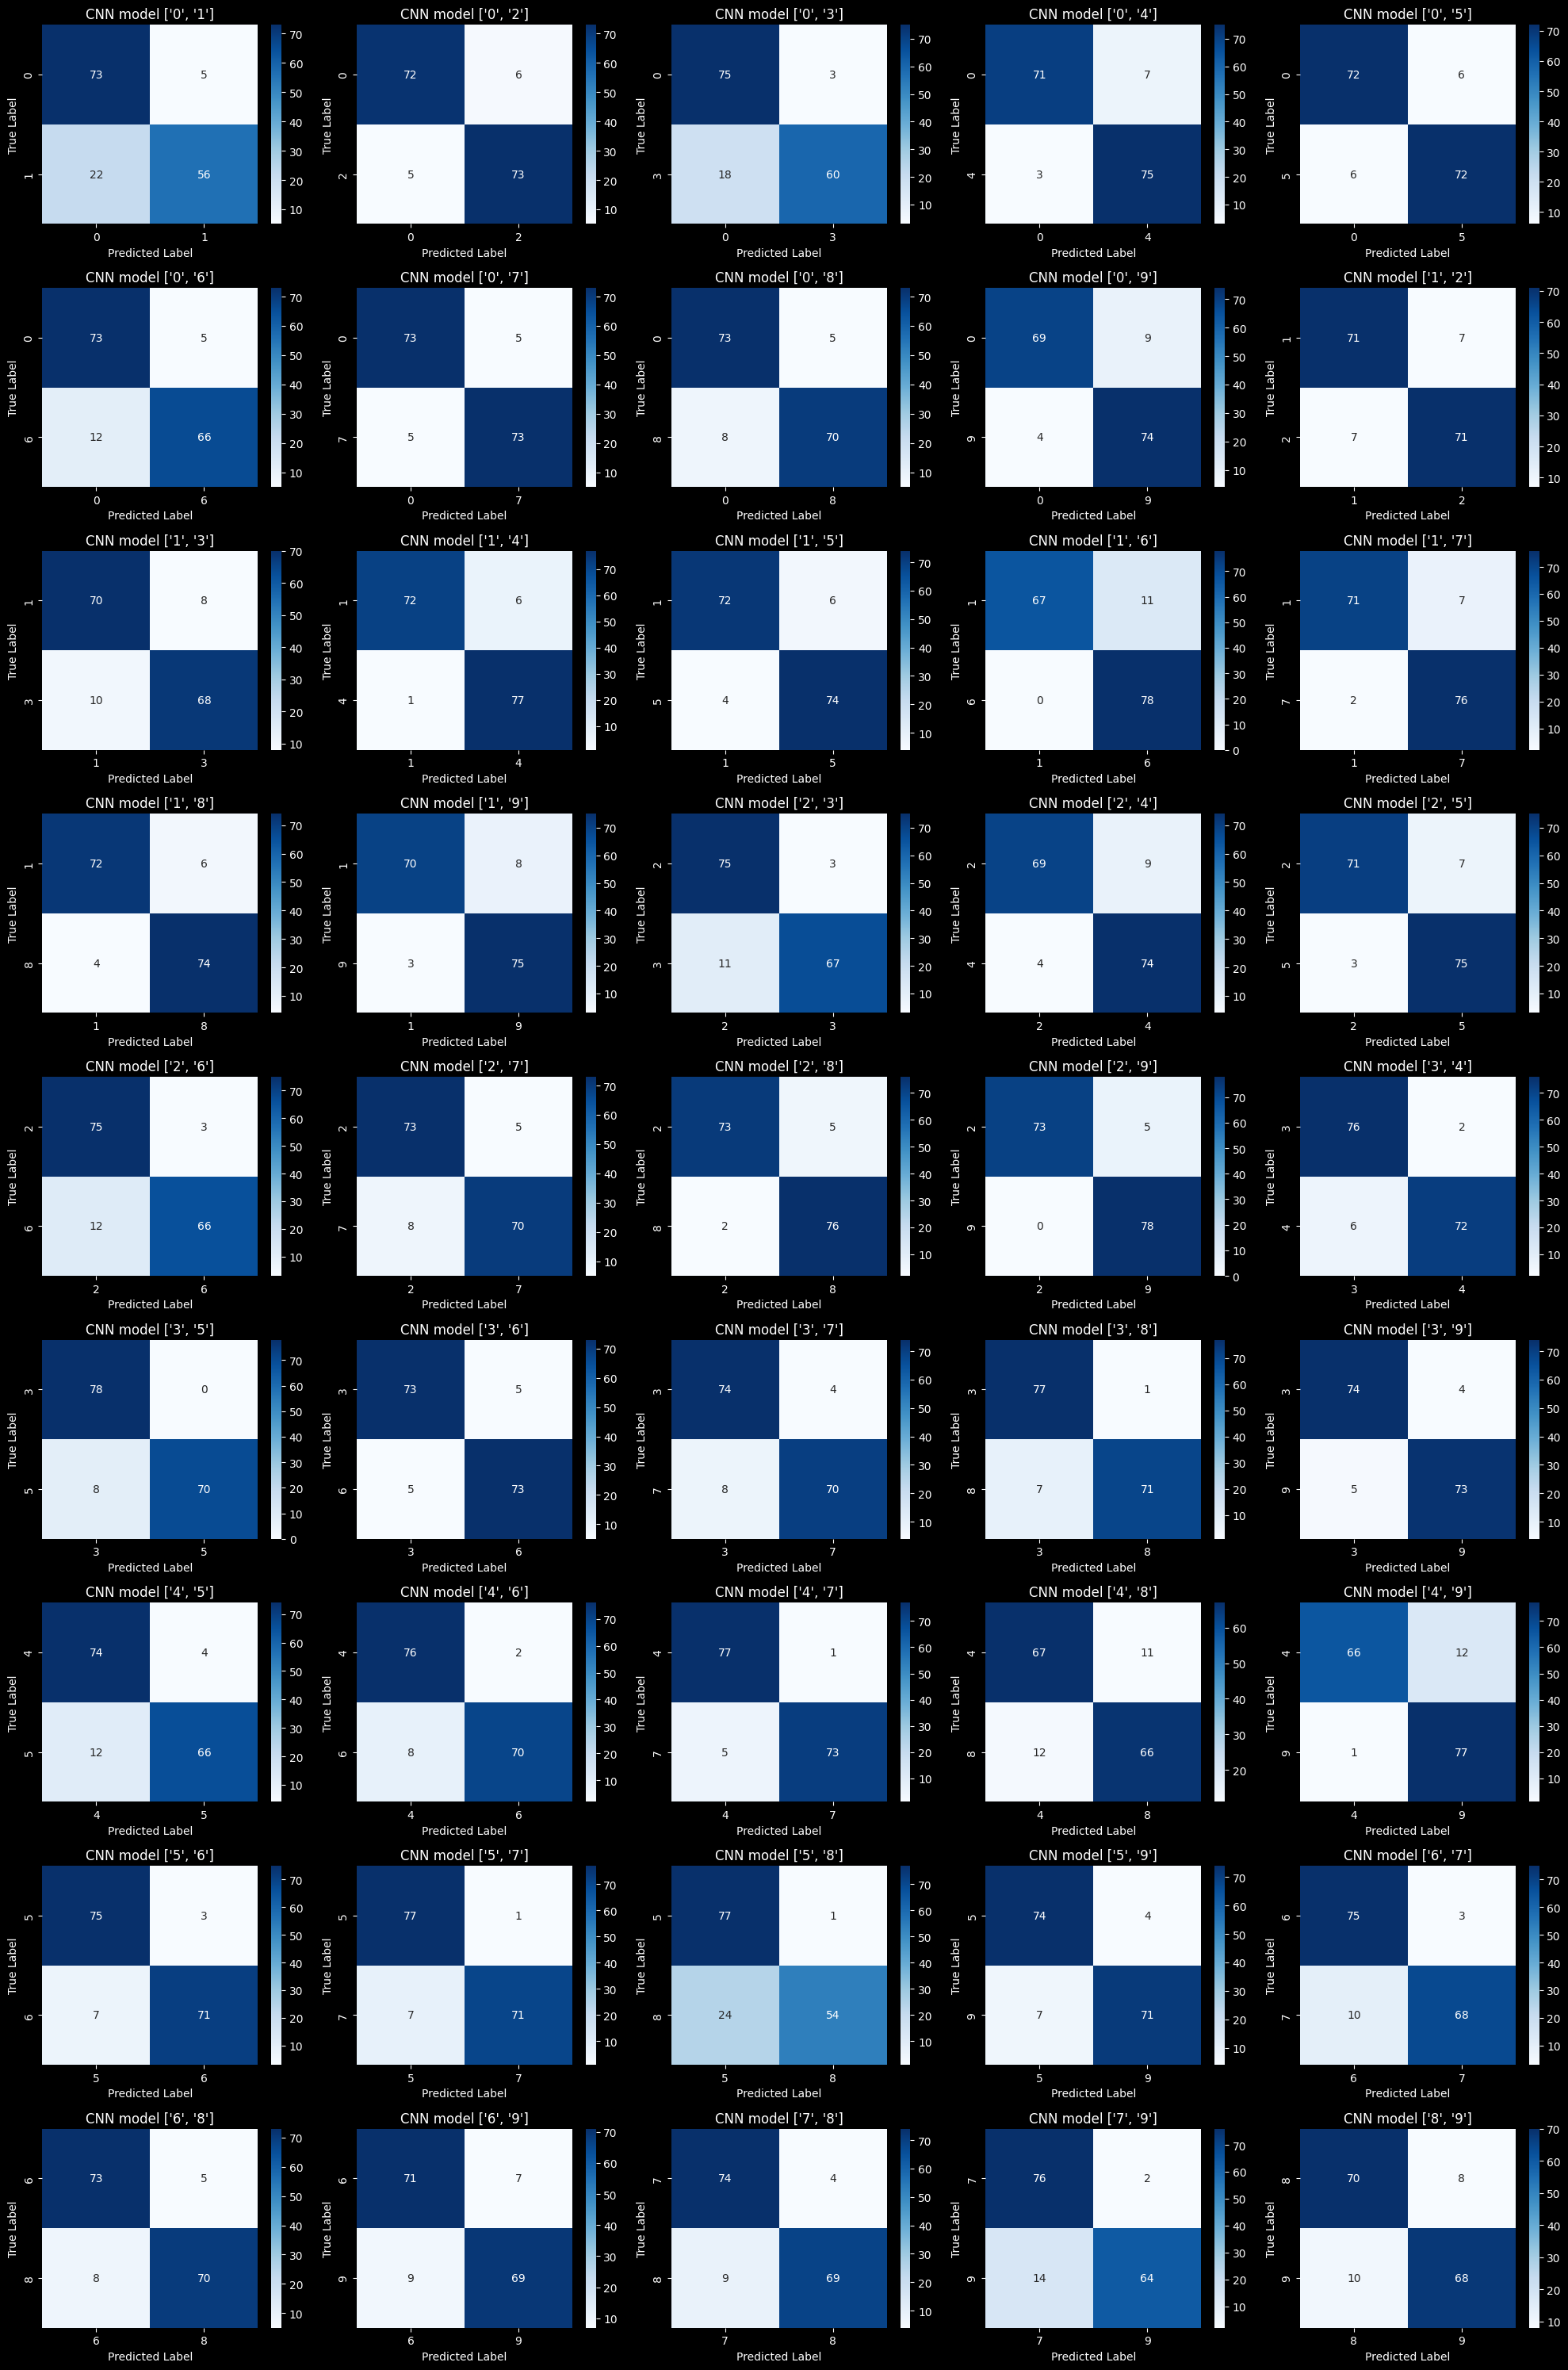

In [93]:
### START CODE HERE ###

from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_confusion_matrix(loaded_models, model_name, cn_and_loader, device):
    
    fig, axs = plt.subplots(9, 5, figsize=(20, 30))
    axs = axs.flatten()

    for i, (model, (class_names, _,test_loader)) in enumerate(zip(loaded_models, cn_and_loader)):
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                preds = (outputs > 0.6).int().squeeze()

                class_ints = list(map(int, class_names))  
                pred_classes = [class_ints[i] for i in preds.cpu().numpy()]  
                all_preds.extend(pred_classes)
                all_labels.extend(labels.cpu().numpy())
   
        cm = confusion_matrix(all_labels, all_preds)

        sn.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axs[i])
        axs[i].set_xlabel('Predicted Label')
        axs[i].set_ylabel('True Label')
        axs[i].set_title(f'{model_name} {class_names}')

    plt.tight_layout()
    plt.show()

model_folder = 'checkpoints/cnn_model'  # หรือ 'checkpoints\\cnn_model' สำหรับ Windows
model_paths = [os.path.join(model_folder, f) 
               for f in os.listdir(model_folder) 
               if f.endswith('.pth')]

loaded_models = []

for path in model_paths:
    print(f"📥 Loading model from: {path}")
    model_instance = CNN()  
    model_instance.load_state_dict(torch.load(path, weights_only=True))
    model_instance.eval()
    loaded_models.append(model_instance)

plot_confusion_matrix(loaded_models,'CNN model',cn_and_loader, 'cpu')
### END CODE HERE ###


### END CODE HERE ###

Questions
1. How does the performance of different models vary across different pairs of numbers in our dataset?
2. Can you identify the number pairs where the Neural Network model performs best and worst? Explain why the NN model is able/unable to classify these specific pairs based on the visualization of feature maps of each node in each layer.
3. Analyze and compare how MLP and CNN models perform on the dataset compared to the Neural Network model.  Identify scenarios where MLP and CNN outperform or underperform the NN. Explain the reasons behind these performance differences. Consider factors like the underlying structure of the data and the specific strengths of each model architecture.
4. According to your observations from questions 1-3, propose specific strategies to improve the performance of each model (NN, MLP, CNN) on this dataset. Consider factors such as data preprocessing, data augmentation, or potential changes to the model architecture itself. Justify your suggestions based on the strengths and limitations identified in the previous questions.
